# Understanding Technology Team Velocity at Scale

John C. Flournoy [](https://orcid.org/0000-0003-1735-1221) (Pluralsight)  
Carol S. Lee [](https://orcid.org/0000-0002-6909-6157) (Pluralsight)  
Catherine M. Hicks [](https://orcid.org/0009-0007-5657-1661) (Pluralsight)  
Maggie Wu (Pluralsight)  
February 27, 2025

Understanding factors that influence software development velocity is crucial for engineering teams and organizations, yet empirical evidence at scale remains limited. We analyze cycle time—a widely-used metric measuring time from ticket creation to completion—using a dataset of over 55,000 observations across 216 organizations. Through Bayesian hierarchical modeling that appropriately separates individual and organizational variation, we examine how coding time, task scoping, and collaboration patterns affect cycle time while characterizing its substantial variability across contexts. We find precise but modest associations between cycle time and factors including coding days per week, number of merged pull requests, and degree of collaboration. However, these effects are set against considerable unexplained variation both between and within individuals. Our findings suggest that while common workplace factors do influence cycle time in expected directions, any single observation provides limited signal about typical performance. This work demonstrates methods for analyzing complex operational metrics at scale while highlighting potential pitfalls in using such measurements to drive decision-making. We conclude that improving software delivery velocity likely requires systems-level thinking rather than individual-focused interventions.

In [ ]:
knitr::opts_chunk$set(message = FALSE, warning = FALSE, error = FALSE)
library(knitr)
library(flextable)
library(data.table)
library(posterior)

This is posterior version 1.5.0


Attaching package: 'posterior'

The following objects are masked from 'package:stats':

    mad, sd, var

The following objects are masked from 'package:base':

    %in%, match

# Introduction

Understanding the factors that affect the delivery of software at an organizational level offers businesses and engineering teams the knowledge to deliver value to users, maintain competitiveness, and improve developer experience. Given engineering teams’ fundamental role in software delivery, the velocity of their work—that is, the time it takes for task completion—has emerged as a focal point of empirical investigation, particularly through measures like cycle time which captures the duration between ticket opening and ticket closing. Moreover, cycle-time is seen by engineers as the most useful metric of engineering productivity according to a prominent industry report \[@careyWhy70Engineers2024\].

While cycle time is often treated as an indicator of productivity per se, the concept of productivity remains poorly specified in software engineering contexts, where outputs fundamentally differ from the more readily quantifiable measures used in traditional industrial production. Specific units of work are rarely identical across time for a person, within a team, or across teams. The interpretation of cycle time therefore presents particular challenges because variations could reflect differences in work patterns, task assignment, and organizational contexts rather than differences in some underlying rate of task completion.

Nevertheless, the intuitive appeal of cycle time and its widespread use in practice make it a valuable focus for empirical investigation. The above-mentioned complexities necessitate sophisticated statistical methods to detect the unique impact of multiple factors, while carefully characterizing the variability practitioners can expect in day-to-day and month-to-month observations of cycle time. Through rigorous statistical modeling of longitudinal data across multiple organizations, we can both characterize its variability across real-world contexts, while demonstrating methodological approaches for analyzing such complex operational metrics. This analysis also allows us to detect systematic influences from factors commonly believed to affect developer productivity: task scoping, focused work time, collaboration, and time of year.

Our investigation leverages a unique dataset comprising over 11,398 contributors at 216 organizations across diverse industries. This work makes two primary contributions. First, we demonstrate a model for statistically investigating software activity data at both a larger and more longitudinal scale than previous empirical research, allowing us to characterize how cycle time varies across software development contexts (i.e., individuals, organizations, and variable process factors), using hierarchical modeling that appropriately separates individual and organizational variation, combined with the careful disaggregation of within- and between-person effects. This approach allows us both greater precision and nuance in describing effects as well as the ability to highlight potential pitfalls in using such measurements to drive decision-making. Second, we incorporate these multiple measures of process factors simultaneously to isolate unique effects, including a novel measure of collaboration operationalized as degree centrality, taking initial steps toward reflecting the impact of the interactive nature of software development in large-scale analyses of activity data.

Our research questions are:

RQ1. How do common workplace and software development process factors impact cycle time?

RQ2. How much between- and within-person variation is there in cycle time?

The paper proceeds as follows: We first review the literature on software productivity measurement, examining cycle time’s relationship to broader discussions of developer performance. We then present our methodology for analyzing cycle time variation using Bayesian hierarchical linear models. Our results examine both population-level effects and the substantial variation observed between individuals and organizations. We conclude by discussing implications for practice and future research directions.

# Background

## Productivity

The use of cycle time in the academic and industry literature is almost always as part of a discussion of productivity. This may be in part because cycle time and related metrics are one of the only so-called objective quantitative windows we have into the process of software production (but note that self-reports of perceived productivity are also potentially valid measures of this process). For this reason, it behooves us to discuss the literature on productivity, even as we position this analysis as specifically analyzing what we consider to be at best a very distal indicator of whatever it is people mean when they use the word “productivity.”

Defining software team productivity and performance is a highly contentious exercise and many different definitions are given by both practitioners and researchers \[@fraserNoSilverBullet2007; @hicksDeveloperThrivingFour2023; @hicksDeveloperThrivingFour2024; @murphy-hillWhatPredictsSoftware2021; @sadowskiSoftwareDevelopmentProductivity2019\]. Perceptions of what counts as successful software work can meaningfully differ across individuals and roles, as when engineering managers tend to focus on long-term outcomes and individual developers focus on activity, for example \[@hicksDeveloperThrivingFour2023; @storeyHowDevelopersManagers2022b\]. Across workplaces, measures of time have been frequently used to assess productivity even while the shortcomings of these measures are also widely acknowledged \[@griffinMetricsMeasuringProduct1993\]. Alternative measures include self-ratings or peer evaluations \[@murphy-hillWhatPredictsSoftware2021; @ramirezMeasuringKnowledgeWorker2004\] and in software engineering, operationalizations of code work such as lines of code \[@blackburnImprovingSpeedProductivity1996; @maxwellSoftwareDevelopmentProductivity1996\]. These have obvious limitations in that the meaning of a particular unit for any of these metrics may be different depending on context \[@sadowskiSoftwareDevelopmentProductivity2019\]. Some researchers have sought solutions to this problem by asking individuals to rate their own level of, or satisfaction with, productivity \[@hicksDeveloperThrivingFour2023; @storeyTheorySoftwareDeveloper2021\]. While it is plausible that perceived productivity could be a good indicator of productivity, it is still not free of the context effects that are often levied as critiques of more “objective” metrics, and self-report, while perhaps overcoming some shortcomings of other methods, bring with them another set of measurement issues.

The difficulty of quantifying productivity arises even prior to the step of choosing one or several indicators. There is often a lack of clear distinction between production (quantity of output regardless of resources provided), productivity (quantity of output given the resources provided), and performance (flexibility, adaptability, dependability, sustainability, and quality of output over time) \[@hicksDeveloperThrivingFour2023\]. As any software developer will be aware, this conceptual complexity is likely the result of the various ways their work counts for professional development, for the success of the product, and for simply meeting deadlines. This piece of research does not aim to solve the issue of how we conceive of productivity but instead seeks to take a deep look at a single popular metric in order to showcase, first, the many factors (themselves, a subset of possible influences of productivity) that affect cycle time, and second, how observing this metric over time informs our view of the ways cycle time varies both within and between people. These views will be helpful both to illuminate specific properties of cycle time as a measure but also to demonstrate how one might approach an in-depth analysis of either “objective” or self-report metrics of productivity.

## Evaluating individual developer performance

Given the difficulty of appropriately defining productivity, the many choices in measuring it, and the potential cost of being measured, it is understandable that software developers have an ambivalent stance about the measurement of both work activity and productivity, that metrics adoption can be fraught with failure \[@bouwersSoftwareMetricsPitfalls2013\], and that social or socio-technical affordances can be strongly associated with self-reported productivity and necessary to obtain a full picture of software team experience beyond project and technical metrics \[@hicksDeveloperThrivingFour2023; @murphy-hillWhatPredictsSoftware2021\].

Developers whose teams use metrics generally see those metrics as helpful, and developers who report agreement with team-level metrics tend to report higher perceived productivity \[@hicksDeveloperThrivingFour2023; @hicksDeveloperThrivingFour2024\]. However, paired with this are some indicators of uncertainty in whether and how metrics are being tracked or used \[@hicksDeveloperThrivingFour2023\], there is often backlash against any attempt to define or popularize such metrics \[@bruneauxWhatMcKinseyHas2024; @chhunejaWhy50Developers2024; @coteOnlyPeopleWho2023; @finster5MinuteDevOps2023; @oroszMeasuringDeveloperProductivity2024; @oroszMeasuringDeveloperProductivity2024a; @rigginsWhatMcKinseyGot2023; @terhorst-northMcKinseyDeveloperProductivity2023; @terhorst-northWorstProgrammerKnow2023; @walkerConsUsingSPACE2023; @walkerEverythingWrongDORA2023\], and there is concern about mismeasurement by managers inside of organizations \[@hicksDeveloperThrivingFour2023\], which is part of a broader discussion of surveillance and the discontent it can generate for workers \[@ballWorkplaceSurveillanceOverview2010; @grisoldDigitalSurveillanceOrganizations2024; @mettlerConnectedWorkplaceCharacteristics2024\]. More troublingly, recent scholarship on sociocognitive experiences in the workplace has proposed that severe experiences of employees being treated by an organization as a “mere tool” or a resource may create organizational dehumanization leading to many negative impacts on both well-being measures and on work outcomes \[@caesensPerceivedOrganizationalSupport2017; @lagiosExplainingNegativeConsequences2022\]. Moreover, there is evidence that metrics might be used differently depending on a person’s visible identities \[e.g, @quadlinMarkWomansRecord2018\].

Likewise, scholarship on employee perceptions of organizational and procedural justice have long documented that when employees perceive a context of organizational injustice, this can exacerbate or redefine experiences of organizational decision-making and performance evaluations \[@brocknerInteractiveEffectsProcedural1994; @brocknerProceduralFairnessOutcome2007\]. Given such larger organizational dynamics, it is likely that whether or not software metrics adoptions are successful is impacted not only by the choice of metric but also by larger contextual factors such as teams’ sociocognitive experiences and expectations around measurement, and the psychological affordances of their environments which may or may not allow them to address measurement concerns \[@hicksPsychologicalAffordancesCan2024\].

We lack holistic evidence about what practitioners in software development believe about developer performance and ability; some reports from researchers with samples at large technology companies have suggested both that definitions of productivity can vary widely between managers and developers, and that software developers perceive many potential trade-offs between types of technical goals, e.g. that quality and speed may be unattainable together \[@storeyHowDevelopersManagers2022\].

One “industry myth” which is referenced frequently in practitioner commentary is the idea of a “10x engineer”: this position alleges that some small outlier population of software developers consistently outperform others on key development tasks. Potentially springing from small case studies examining a handful of developers’ time spent solving small laboratory tasks \[@sackmanExploratoryExperimentalStudies1968; discussed in @nicholsEndMythIndividual2019\], this “law” was generalized from only twelve individuals, uses time spent on the tasks as an estimate of both effort and cost, has failed to replicate in larger examinations of developer performance on similar tasks, and failed to acknowledge large within-individual variation in task performance \[@nicholsEndMythIndividual2019; @shrikanthAssessingPractitionerBeliefs2021\].

Nevertheless, the idea that “10x engineers” exist and that some individuals in software engineering outperform others by a “rule” of 10x has been cited often and codified in industry commentary, \[e.g., @brooksMythicalManmonthEssays1975\]. Modern commentary on this idea frequently refers to it as a myth, but it is also discussed as a potentially real phenomenon[1]. In our previous work, we have noted that some software practitioners hold field-specific ability beliefs that software development success and productivity is attributable to a quality of “innate brilliance”, and that this belief among practitioners may create a higher likelihood of experiencing threat and anxiety in the face of rapid role change and technological shifts to developer workflows \[@hicksNewDeveloperAI2024\]. Broad reviews on drivers of software development outcomes, particularly frictions in the form of team “debt,” also suggest that social-psychological aspects of shared work processes may be a significant contributor to these outcomes separate from individual performance \[@ahmadPandorasBoxSocial2024\].

Despite some recognition that the 10x engineer is a problematic concept, the conflictual measurement of productivity and its use as a tool of surveillance and punishment contra the interests of individual contributors (but to the benefit, at least ostensibly, to a company’s profitability) continues with full-throated glee. A recent unpublished study claims that nearly 10% of engineers contribute almost no work; that is to say, it raises the boogeyman of the 0.1x engineer as the 10x engineer’s inverse[2]\[@obstbaumOngoingResearchSoftware\]. The measure of productivity used is something half-way between the objective and self-report: an unspecified machine-learning model trained on expert ratings of the quality and work necessary to complete 70 commits \[@denisov-blanchPredictingExpertEvaluations2024\]. Unlike prior work, this method lacks both the transparency of “objective” measures and the temperance of self-report measures.

In taking a deep dive into cycle time, this project does not address every implementation challenge and organizational affordance that may define whether organizations can ensure a healthy and sustainable practice around the measurement of work activity. However, we believe that a more robust understanding of the dynamics of cycle time may help practitioners avoid pitfalls in relying on velocity measures while evaluating software work. We hope to describe the complexity in a way that at adds some clarity and aligns with the experience of software developers in practice.

## Cycle Time

Because lower cycle times typically indicate faster delivery times and more efficient software processes, cycle time has long been taken as a key indicator of team health, developer productivity, and team efficiency \[@clincySoftwareDevelopmentProductivity2003; @agrawalSoftwareEffortQuality2007; @carmelCycleTimePackaged1995; @eversImprovingEngineeringProductivity1998; @guptaKeyDriversReduced1998; @nanImpactBudgetSchedule2009; @ruvimovaExploratoryStudyProductivity2022; @sadowskiRethinkingProductivitySoftware2019; @trendowiczChapter6Factors2009\]. This suggests that understanding factors that influence cycle time may lead to insights into factors that are important to understand for understanding productivity in general. At minimum, examining cycle time can provide a description of the complexity of factors that impact this popular metric.

Cycle time examines one aspect of the speed of software delivery by measuring the time between task start and task delivery. It has consistently been described by industry research as one of the best and most trusted metrics for software productivity \[@careyWhy70Engineers2024\]. In this same report, similar metrics also showed preference, such as lead time, deploy frequency, and change failure rate. The common thread across these metrics is that the unit of work is defined by the team or company in relation to goals that serve the strategic interests of the project. While there is a good deal of nuance with respect to what goes into setting these units up, they are both discrete (and so “objective”-feeling) but also defined, often collaboratively, with respect to the outcomes that matter. This is in contrast to lines of code, for example, which may or may not be relevant to the goals of the engineering teams, and which is avoided by 70% of respondents in the same industry report. Cycle time may also be considered an important part of developer experience as a component of what leads to a fluid-feeling development and release cycle \[@greilerActionableFrameworkUnderstanding2022a\].

In calls to re-examine the complexity of developer productivity, researchers have argued that velocity measures are highly task-dependent, and do not represent the quality of work done or other, longer-term measures of the impact of work \[@sadowskiSoftwareDevelopmentProductivity2019\]. It is also possible for velocity measures to have multiple directional relationships with desired outcomes depending on software developers’ larger context. For instance, hypothetically speaking, an increase in velocity may associate with more success for a software team when this increase arises because the team engages in process improvements, creating processes that help them to move more quickly through development tasks, and thereby meet a critical deadline for a product launch, leading to business outcomes which then lead to more resources for the team. However in a different scenario, an increase in velocity may be associated with more failures for a software team, for instance, if velocity changes arise because the team begins to eschew quality control processes, eventually leading to costly critical business failures.

Nevertheless, time and output-based measures are frequently used as an outcome measure to make recommendations for software engineering practices, e.g. in evaluating the perceived impact of technical debt \[@beskerTechnicalDebtCripples2018\]. These measures have the added benefit of having a concrete referent that is simple to measure and inexpensive and convenient for teams trying to track productivity to collect.

The utility of cycle time has subsequently led to numerous industry experts recommending that engineering managers and leaders track their teams’ cycle times. However, leaders are provided less guidance on how to decrease cycle time. As such, leaders are left with the dilemma of being aware of their cycle times, but not understanding how to improve their cycle times in an evidence based way. Four major areas have been proposed to impact cycle time: (1) organizational structure and climate, (2) reward system, (3) software development process and (4) the use of software design and testing tools \[@clincySoftwareDevelopmentProductivity2003\]. We focus in this paper on factors from (3) software development processes, in part because measurements of these processes continue to gather significant interest from the technology industry and are plausibly mobile levers that can be manipulated at the level of an engineering team. They are also themselves relatively easy to measure and track at the team level if a software team within a larger organization were to decide they wanted to try to shift their processes and take measurements to make sure they were successful. We have argued elsewhere that organizational structure and climate are also relatively easy to measure and are powerful levers that should be more often targeted \[@hicksCumulativeCultureTheory2024; @hicksDeveloperThrivingFour2023; @hicksDeveloperThrivingFour2024\], though for the present work we focus on (3) also in part to keep the scope of this analysis manageable.

To reduce cycle times at the level of software development process, the software industry currently recommends strategies centered around three major themes:

1.  increased coding time
2.  improved task scoping
3.  improved collaboration

Industry convention rationalizes that increased coding times increases the amount of code committed and pull requests merged, thus moving tickets through their life cycle more quickly. Improved scoping can similarly yield more efficient teams by breaking work down into more manageable chunks and reducing the amount of unplanned work from bugs and defects. Finally, industry reports posit that improved collaboration can reduce the time it takes for developers to review PRs and increase review rates \[@flowHowIncreaseSoftware; @gralhaReduceCycleTime2022; @waydevCycleTimeFormula2021\]. However, this has not yet been examined empirically. That is, although industry convention dictates that these practices work to reduce cycle time, we have yet to generate real world evidence of their effectiveness. We focus on these three areas as possible factors that impact cycle time.

# Research design and methodology

All code can be found in the repository for this paper.

-   [ ] To be linked

## Data Selection and Characteristics

To examine coding time, task scoping, and collaboration as predictors of cycle time over time, we centered our analysis on a large, real-world dataset of git and ticketing data of 55,619 observations across 12 months in 2022 from 11,398 users in 216 organizations of varying sizes and industries. We chose to use longitudinal data across 12 months, as it allowed us to examine fluctuations within a person’s workflow as well as different stable tendencies between people.This data was available via partnerships between a software metrics tool\[^Formerly Pluralsight Flow, now Flow at Appfire. All authors were research scientists or data scientists employed at Pluralsight at the time that this data was collected and analyzed.\] which was incorporated into the workflows of real working software teams, and the 216 organizations which opted in to this tool at any point during the 12 month analytic window. Notably, because this tool was adopted on an organizational level (following partnership agreements that include organizational opt-in and security audits), users themselves did not have to be active users of the software metrics tool itself in order to be included in this dataset, and git and ticketing data was available retrospectively for dates prior to the implementation of the tool in the organization. In other words, the git and ticketing data included in this analysis is not predicated on being an individual user of the software metrics tool, nor on the software metrics tool being used at the organization, as our dataset contains measures both before and after the software metric tool implementation at the organization, and implementation dates for organizations vary across the 12 month period.

Data were selected for analysis based on whether users actively contributed code during the time frame of the study. The 216 organizations included in this dataset had between 1–2,746 individuals in the dataset, with 90% of organizations being represented by more than 12 users, and in previous pilot surveys used to inform the design of this project, professional software developer users from these organizations described their main industries as ranging from Technology, Finance, Government, Insurance, Retail, and others, indicating a wide diversity of business use cases and engineering contexts were present in this sample.

## Computing study variables

Using the most complete data for each user, we used the mean to aggregate each variable at the *month* level and the *year* level (see below for more details specific to each variable). For each predictor, we then subtracted each person’s yearly average from their monthly data to produce a within-person deviation variable. This allowed us to disaggregate effects on the outcome due to yearly-level individual differences and within-person, month-to-month fluctuations \[@curranDisaggregationPersonPerson2011\]. This also allowed us to avoid averaging between-person and within-person differences into a single effect estimate. These effects can be different even in the sign of the effect, for example with a positive relationship between some time-invariant factor and the outcome of interest at the between-person level, and a negative relationship between the same factor measured across time and within-person variation over time. A common example that is highly relevant to most technical and knowledge workers is typing speed and errors. Imagine someone trying to type as fast as they can; it is obvious that they will make more errors the faster they type, evincing a negative association between speed and errors. However, if one simply measures the typing speed and error rate of many people, it should be clear that we would see that faster typists tend to make fewer errors, perhaps because of differences in typing experience. In this study, we want to be able to examine average differences between people’s cycle time aggregated at the year while also examining what is associated with cycle time deviations from that yearly trend month-to-month. All year-level individual differences variables were centered at their mean. Exceptions or addenda are mentioned below. See @tbl-variables for a brief list of variables.

### Cycle Time

This is the dependent variable in these analyses. After computing the cycle time for each closed ticket in seconds, we found the median cycle time for each month for each user using all tickets *opened* in that month. For example, a ticket opened on the 9th of April, and closed on the 3rd of May would contribute 2,246,400 seconds to the calculation of the median for April.

### Unclosed Tickets

We were not able to observe the closing date for every ticket given our data collection cutoff of March 7, 2023, and so it is plausible that we underestimate the median cycle time in a way that depends in part on how many ticket closing times we do not observe. For this reason, we also computed the proportion of tickets opened in that month that had not been closed by the end of our data collection. For example, any ticket opened in April, 2022 but not closed by March 7, 2023 would count toward the proportion of unclosed tickets for that month. We transformed proportions from $[0,1]$ to $(-\infty, \infty)$ using the logistic quantile function (with minimum and maximum proportions forced to be .01 and .99 respectively). We use this in the regressions below as a control variable to adjust for this possibility.

### Time (Month, and within-quarter month)

We examined time in two ways: monthly and quarterly. Months were represented as numeric values (i.e. January = 1, February = 2) and centered at month 7, which allows us to interpret certain quantities like the intercept as the average cycle time in the middle of the year. Additionally, because quarters provide meaningful business cadences that may impact engineering work, for instance in that some organizations set quarterly goals at the beginning of each quarter and push to meet those goals at the end of each quarter and that key product deadlines may occur systematically toward the end of quarters, we accounted for any effects of quarterly cycles by using an indicator for the within-quarter month, centered at the middle of the quarter (e.g., -1 for the first month of the quarter, 0 for the middle month, and 1 for the last month of the quarter). This approach allowed us to capture a more stable and realistic trajectory of change over the course of the year.

### Team Size

To control for any influence of team size on cycle time, we compute each individual’s team size as the average size of all teams that individual belongs to as defined by individuals’ co-located activity data. Specifically, in the database used, an individual contributor is given membership in any team that they have worked in, and this is updated retroactively. For each individual, we find all teams that person is a member of, compute the size of that team, and then average across those team sizes if an individual is a member of multiple teams. As such, this number is a very rough indicator of the size of teams an individual tends to be a part of and is static across the year. This is a limitation of the database. This is then entered as an individually-varying continuous variable to control for some of the effect of team size on an individual’s cycle time.

### Coding days

Coding days was summarized as the average number of days per week that a developer made at least one commit. We divided the number of coding days in a month by the total number of days in that month and multiplied by seven to aid in interpretation.

### Total Merged PRs

One frequently proposed best practice in software work, intended to lead to outcomes such as improved task scoping, involves breaking work into smaller and more manageable chunks or pull requests that can be finished more quickly \[@kudrjavetsSmallCodeChanges2022; @linesWhyEliteDev2023; @riosaWrittenUnwrittenGuide2019; @zhangPullRequestLatency2022\]. As such, we used the number of total merged pull requests as one measure of task scoping. To calculate this, we counted the number of merged pull requests for each user for each month.

### Percent Defect Tickets

Another potentially beneficial signal in software activity data is the reduction of unplanned work on bugs and defect tickets, which is also proposed as a bottleneck on improving cycle time \[@paudelMeasuringImpactTechnical2024; @paudelMeasuringImpactTechnical2024; @rosserSystemsPerspectiveTechnical2021; @toxboeCycleTime2023\]. As such, we used the percentage of defect ticks as another measure of task scoping to represent unplanned work that may interfere with timely completion of planned work. This may also be a downstream signal of individuals’ opportunity for focused work time and code quality. To account for this possibility, for each user, for each month, we computed the percent of tickets that were defect tickets.

### Degree centrality

We measured collaboration by calculating degree centrality. To evaluate degree centrality, a metric derived from network analysis, we employed a framework where developers were treated as nodes within the network, and their interactions in the form of Pull Requests (PRs) were regarded as connections. In other words, any contribution of code to the same pull request constituted a collaboration edge between developers. We normalized each centrality value by dividing by the total number of developers constituting the organizational network. The calculations were executed using the Python package Networkx \[@SciPyProceedings_11\]. This particular variable serves as an effective proxy for quantifying the extent of collaboration among developers. We multiply the normalized degree centrality, which is between 0 and 1, by 100.

### Comments per PR

Another indicator of collaboration is the frequency of comments within PRs. We undertook a comprehensive examination of all PRs that were successfully merged in the year 2022 and, for each user, calculated the average number of comments per PR that they authored each month. This served as a measure to gauge the depth of collaboration exhibited during the development and review process.

|  | Variable | Variable Description |
|:----------|:--------------------|:----------------------------------------|
| Productivity | Cycle Time | Avg time from ticket start to end |
|  | Proportion unclosed tickets | Control variable to account for tickets missing cycle time |
| Time | Month | Continuous time variable coded as month number |
|  | Within-quarter month | Index of the month number within each quarter year |
| Team Context | Team size | Average size across all teams a individual is on |
| Coding Time | Coding Days per Week | Avg number of coding days a week |
| Task Scoping | Total Merged PRs | Total number of merged PRs per developer |
|  | Percent Defect Tickets | Percent of all tickets that are defect tickets |
| Collaboration | Degree Centrality | Score based on the number of reviewers a developer has worked with |
|  | Comments per PR | Number of comments per pr a developer is the author on |

## Analytic Approach

The models described below are fit using `brms` \[v2.21.6, @burknerAdvancedBayesianMultilevel2018; @burknerBrmsPackageBayesian2017\], interface the the Stan probabilistic programming language for Bayesian sampling \[v2.35.0, @gelman\], with the `cmdstanr` backend \[v0.8.0, @gabryCmdstanrInterfaceCmdStan2024\], in R \[v4.3.2, @rcoreteamLanguageEnvironmentStatistical2023\].

We developed a model of monthly average ticket cycle time conditional on the following predictors: within-quarter month number, team size, proportion of unclosed tickets, month number, yearly means and month-level deviations for coding days per week, total merged PRs, defect ticket percentage, degree centrality, and comments per PR. Specifically, we modeled cycle time as distributed Weibull with two parameters, $\lambda$ (scale), and *k* (shape). The Weibull distribution is often used to model time-to-event data \[@harrellRegressionModelingStrategies2015; @rummelAverageWeibullAnalysis2017\], where *k* determines the change over time in the probability of an event occurring (often called the “hazard rate”), and where $\lambda$ determines the time-to-event for some proportion of the cases (or in other words, how spread out the distribution is). For simplicity, we assume that the shape (hazard rate, *k*) is not influenced by the factors considered, and focus on how these factors affect the scale (time-to-event, $\lambda$) of ticket closures, though we did allow the shape, *k*, to vary across organizations. In short, the Weibull distribution provides flexibility for accurately describing cycle time data that tend to have a bulk of observations at the low end, with a very long tail of more extreme observations.

The model for $\lambda$ is

where $X$ is the matrix of predictors, $\beta$ is the vector of coefficients, $\eta_{\text{org}}$ is random intercepts with mean $\mu_1$ and linear slopes of month with mean $\mu_2$ for each organization, and $\eta_{\text{org:user}}$ is random intercepts with mean $\mu_3$ and linear slopes of month with mean $\mu_4$ for each user nested within organization. The specific predictors in $X$ are within-quarter month number, team size, proportion of unclosed tickets, month number, yearly means and month-level deviations for coding days per week, total merged PRs, defect ticket percentage, degree centrality, and comments per PR. We also include interactions between month number and the following: team size, proportion of unclosed tickets, and each of the yearly mean predictors. This allows us to account as completely as possible for our control variables (team size and proportion of unclosed tickets), and allow the effect of month on cycle time to vary by the individual differences variables (e.g., to account for the possibility that someone who has higher coding days per week shows a less steep decrease in cycle time across the year than someone with lower coding days per week).

The model for *k* is

where $\zeta_{\text{org}}$ is a random intercept with mean $\mu_5$ each organization.

Conceptually, this model allows a unique distribution of cycle times (as determined by the random intercepts for both $\lambda$ and *k*) for each organization. It also allows the scale of the distribution of cycle times to vary for each user due to the random intercept for $\lambda$. The effect of time (month number) on the scale of the distribution of cycle times is also allowed to vary across organizations as well as users due to the random slopes (with means $\mu_2$ and $\mu_4$). This strategy allows two advantages: first, we account for multiple sources of variance that allows our estimates of the effects of interest to be more precise; and second, we are able to provide estimates of this variation across organizations and users. This variation itself is of interest given the various myths mentioned in the introduction about developer performance.

We model the effect of proportion of unclosed tickets and month number as smooth functions of the covariate using thin-plate splines for increased flexibility \[@woodGeneralizedAdditiveModels2017\]. Briefly, thin plate splines (functions made up of smoothly connected segments) allow for flexible, non-linear relationships between predictors and the response variable. These splines are penalized to prevent overfitting, balancing model flexibility and complexity. The interactions between month number and our control variables are parameterized as additional smooth functions of month number multiplied by these variables. While our focal model parameterizes the interactions between year-level means and month number as linear coefficients on multiplicative combinations between the two variables, we also examined a model that uses additional smooth functions of month number multiplied by these variables to allow for additional complexity. We provide the model output for this sensitivity analysis in a supplement.

We set weakly-informative priors centered at zero for all parameters, except for the intercept for $\lambda$ and *k* which were centered on their approximate values in the data (consistent with the default behavior of `brms`). We performed prior-predictive checks to ensure our prior specification generated data that covered and exceeded the space of our observations. Given the complexity of the model, we also specified initialization of parameters at small plausible values (e.g., zero for coefficients, .1 for standard deviations of random effects). Full prior and initialization specifications are available in the analysis code.

We sampled from 4 chains with 2,000 total iterations each, discarding the first 1,000 iterations as warmup. Inferences were made on 4,000 post-warmup draws from the posterior probability distribution from the 4 chains.

## Inferences

We take a Bayesian approach to making claims about the sign of effects (i.e., whether an association between two variables is positive or negative), and to describing its magnitude. Instead of the common but fraught frequentist approach of describing whether an effect size is unlikely given the assumption of an unrealistic point-null hypothesis, we try to give the reader a sense of the actual probability that the sign of an effect is in a particular direction, and what the impact of the factor is on cycle times in terms that are easy to interpret \[@GelmanPowerCalculationsAssessing2014\].

In more precise statistical terms, unless otherwise stated we describe the posterior of parameters and predictions using the median of the distribution, and characterize its variation using the highest posterior density interval (HDI) which is defined as the interval that contains a specified percentage (usually 95%) of the most probable values of the parameter \[@kruschkeRejectingAcceptingParameter2018\]. We make general descriptive inferences based on the probability that a parameter has the sign of the posterior density’s median value. For example, if 80% of the posterior density of the slope of the effect of month on cycle time is of the same sign as the density’s median, and that median is negative, we would say something like, “given the model and the data, there is an 80% chance that there is a decrease in cycle times across the year.”

## R packages

R packages explicitly loaded in this analysis and manuscript preparation include brms \[v2.22.7, @burknerAdvancedBayesianMultilevel2018; @burknerBayesianItemResponse2021; @burknerBrmsPackageBayesian2017\], cmdstanr \[v0.8.0, @gabryCmdstanrInterfaceCmdStan2024\], data.table \[v1.15.4, @barrettDatatableExtensionDataframe2024\], ggplot2 \[v3.5.0, @wickhamGgplot2ElegantGraphics2016\], flextable \[v0.9.5, @gohelFlextableFunctionsTabular2024\], knitr \[v1.46, @xieDynamicDocumentsKnitr2015; @xieKnitrComprehensiveTool2014; @xieKnitrGeneralpurposePackage2024\], marginaleffects \[v0.19.0, @arel-bundockMarginaleffectsPredictionsComparisons2024\], mgcv \[v1.9.0, @woodFastStableRestricted2011; @woodGeneralizedAdditiveModels2017; @woodSmoothingParameterModel2016; @woodStableEfficientMultiple2004; @woodThinplateRegressionSplines2003\], parameters \[v0.21.6, @ludeckeExtractingComputingExploring2020\], patchwork \[v1.2.0, @pedersenPatchworkComposerPlots2024\], posterior \[v1.5.0, @burknerPosteriorToolsWorking2023; @vehtariRanknormalizationFoldingLocalization2021\], rlang \[v1.1.3, @henryRlangFunctionsBase2024\], scales \[v1.3.0, @wickhamScalesScaleFunctions2023\], scico \[v1.5.0.9000, @pedersenScicoColourPalettes2025\], showtext \[v0.9.7, @qiuShowtextUsingFonts2024\], StanHeaders \[v2.36.0.9000, @standevelopmentteamStanHeadersHeadersInterface2020\], and tidybayes \[v3.0.6, @kayTidybayesTidyData2023\].

# Results

Results from the linear model reported below were highly similar to those in the more flexible non-linear model sensitivity analysis described above. Also note that parameters in the table are from a linear model for the distribution of log($\lambda$) and log(*k*), while model expectations are on the response scale and can therefore display curvature even while the model is linear.

The first section of the results concerns the population-level effects and showcases the expectations of cycle time conditional on the various co-varying factors we target. The second section explores the variability in these effects across time, across individuals, and across organizations.

[1] For example, see this [ycombinator thread](https://news.ycombinator.com/item?id=22349531) ([internet archive](http://web.archive.org/web/20240917164935/https://stackoverflow.blog/2024/06/19/the-real-10x-developer-makes-their-whole-team-better/)), and this [StackOverflow blog post](https://stackoverflow.blog/2024/06/19/the-real-10x-developer-makes-their-whole-team-better) ([internet archive](http://web.archive.org/web/20231209171051/https://news.ycombinator.com/item?id=22349531))

[2] in fact, the original paper perhaps even emphasizes the “low performers” more than the “exceptional” stating, “the ‘horrid’ portion of the performance frequency distribution is the long tail at the high end, the positively skewed part which shows that one poor performer can consume as much time or cost as 5, 10, or 20 good ones.” \[@sackmanExploratoryExperimentalStudies1968, p. 6\]

In [ ]:
fe_par_nicenames <- c(b_Intercept = 'Intercept log(\u03BB)',
                      b_shape_Intercept = 'Intercept log(k)',
                      b_within_quarter_month_num_c = 'Within-quarter month',
                      b_team_size_c = 'Team size',
                      b_wi_avg_coding_days_per_week = 'Avg. coding days/week (within-person)',
                      b_yr_avg_avg_coding_days_per_week_c = 'Avg. coding days/week',
                      b_wi_total_merged_prs = 'Total merged PRs (within-person)',
                      b_yr_avg_total_merged_prs_c = 'Total merged PRs',
                      b_wi_defect_tickets_pct_indiv = 'Defect tickets % (within-person)',
                      b_yr_avg_defect_tickets_pct_indiv_c = 'Defect tickets %',
                      b_wi_degree_centrality_monthly_100 = 'Degree centrality (within-person)',
                      b_yr_avg_degree_centrality_monthly_100_c = 'Degree centrality',
                      b_wi_comments_per_pr = 'Comments per PR (within-person)',
                      b_yr_avg_comments_per_pr_c = 'Comments per PR',
                      `b_yr_avg_avg_coding_days_per_week_c:month_num_c` = 'Avg. coding days/week × Month',
                      `b_yr_avg_total_merged_prs_c:month_num_c` = 'Total merged PRs × Month',
                      `b_yr_avg_defect_tickets_pct_indiv_c:month_num_c` = 'Defect tickets % × Month',
                      `b_yr_avg_degree_centrality_monthly_100_c:month_num_c` = 'Degree centrality × Month',
                      `b_yr_avg_comments_per_pr_c:month_num_c` = 'Comments per PR × Month')



ct_model_draws_fe <- readRDS('cycle_time_full_intx_lin_remonth_draws_id-fe.rds')
ct_model_draws_bs <- readRDS('cycle_time_full_intx_lin_remonth_draws_id-bs.rds')
ct_model_draws_re <- readRDS('cycle_time_full_intx_lin_remonth_draws_id-re.rds')
ct_model_draws_sds <- readRDS('cycle_time_full_intx_lin_remonth_draws_id-sds.rds')
ct_model_pars_fe <- parameters::model_parameters(ct_model_draws_fe, 
                                                 digits = 4,
                                                 centrality = 'median', 
                                                 ci = .95, 
                                                 ci_method = 'hdi', 
                                                 test = 'pd', exponentiate = FALSE)
ct_model_pars_bs <- parameters::model_parameters(ct_model_draws_bs, 
                                                 digits = 4,
                                                 centrality = 'median', 
                                                 ci = .95, 
                                                 ci_method = 'hdi', 
                                                 test = 'pd', exponentiate = FALSE)
ct_model_pars_re <- parameters::model_parameters(ct_model_draws_re, 
                                                 digits = 4,
                                                 centrality = 'median', 
                                                 ci = .95, 
                                                 ci_method = 'hdi', 
                                                 test = 'pd', exponentiate = FALSE)
ct_model_pars_sds <- parameters::model_parameters(ct_model_draws_sds, 
                                                 digits = 4,
                                                 centrality = 'median', 
                                                 ci = .95, 
                                                 ci_method = 'hdi', 
                                                 test = 'pd', exponentiate = FALSE)
ct_model_pars_fe_for_text <- ct_model_pars_fe
ct_model_pars_fe$Parameter <- fe_par_nicenames[ct_model_pars_fe$Parameter]
ct_model_pars_fe$pd <- sprintf('% 3.0f%%', ct_model_pars_fe$pd*100)


names(ct_model_pars_fe) <- c('Parameter', 'Posterior Median', 'Lower 95% HDI', 'Upper 95% HDI', 'Sign Probability')

## Population-level effects

We find that all measured factors, both individual-difference and within-person deviations, have a non-zero association with cycle time, with 100% of the posterior distribution for these parameters sharing the same sign (see @tbl-results-fe for point estimates and uncertainty intervals). Within-quarter month showed a very small (relative to other effects shown below) negative association with cycle time, indicating that time to ticket completion is shorter at the end of quarters (@fig-quarter). Team size had almost to no effect on cycle time (@tbl-results-fe). Cycle times tended to decrease slightly over the year (@fig-month). The proportion of unclosed tickets, an important control variable, on average had close to no effect on our measure of average monthly cycle time but interacted with month.

In [ ]:
flextable(ct_model_pars_fe) |>
  colformat_double(digits = 4) |>
  set_table_properties(layout = 'fixed', opts_pdf = list(float = 'float')) |>
  width(j = 1, 1.5, unit = 'in') |> 
  width(j = 2:5, 1.1, unit = 'in') |>
  theme_booktabs(bold_header = TRUE) |>
  align(j = 5, align = 'right', part = 'all') |>
  footnote(i = 1, j = 2,
           value = as_paragraph(
             'Median of the posterior distribution, used as point estimate'
           ),
           ref_symbols = '1',
           part = 'header',
           inline = TRUE,
           sep = '. '
  ) |> 
  footnote(i = 1, j = 3:4,
           value = as_paragraph(
             '95% Highest Density Interval, containing the most probable parameter values with 95% posterior probability mass'
           ),
           ref_symbols = '2',
           part = 'header',
           inline = TRUE,
           sep = '. '
  ) |> 
  footnote(i = 1, j = 5,
           value = as_paragraph(
               'Probability that the effect is in the reported direction, calculated as the proportion of posterior samples with the same sign as the point estimate'
             ),
           ref_symbols = '3',
           part = 'header',
           inline = TRUE,
           sep = '. '
  ) |> 
  fontsize(size = 9, part = "all")

Parameter Posterior Median 1 Lower 95% HDI 2 Upper 95% HDI 2 Sign Probability 3 Intercept log(λ) 14.3484 14.2727 14.4282 100% Intercept log(k) 0.1214 0.0807 0.1585 100% Within-quarter month -0.0085 -0.0188 0.0013 95% Team size 0.0001 -0.0644 0.0560 50% Avg. coding days/week (within-person) -0.0794 -0.0911 -0.0677 100% Avg. coding days/week -0.0839 -0.1100 -0.0587 100% Total merged PRs (within-person) -0.0127 -0.0155 -0.0097 100% Total merged PRs -0.0083 -0.0139 -0.0027 100% Defect tickets % (within-person) -0.0019 -0.0023 -0.0014 100% Defect tickets % 0.0060 0.0049 0.0070 100% Degree centrality (within-person) -0.0023 -0.0040 -0.0006 100% Degree centrality -0.0040 -0.0063 -0.0015 100% Comments per PR (within-person) 0.0046 0.0037 0.0054 100% Comments per PR 0.0098 0.0075 0.0120 100% Avg. coding days/week × Month -0.0047 -0.0098 -0.0001 97% Total merged PRs × Month -0.0007 -0.0017 0.0003 90% Defect tickets % × Month -0.0001 -0.0003 0.0001 78% Degree centrality × Month -0.0001 -0.0005 0.0002 71% Comments per PR × Month 0.0001 -0.0004 0.0005 59% 1 Median of the posterior distribution, used as point estimate . 2 95% Highest Density Interval, containing the most probable parameter values with 95% posterior probability mass . 3 Probability that the effect is in the reported direction, calculated as the proportion of posterior samples with the same sign as the point estimate .

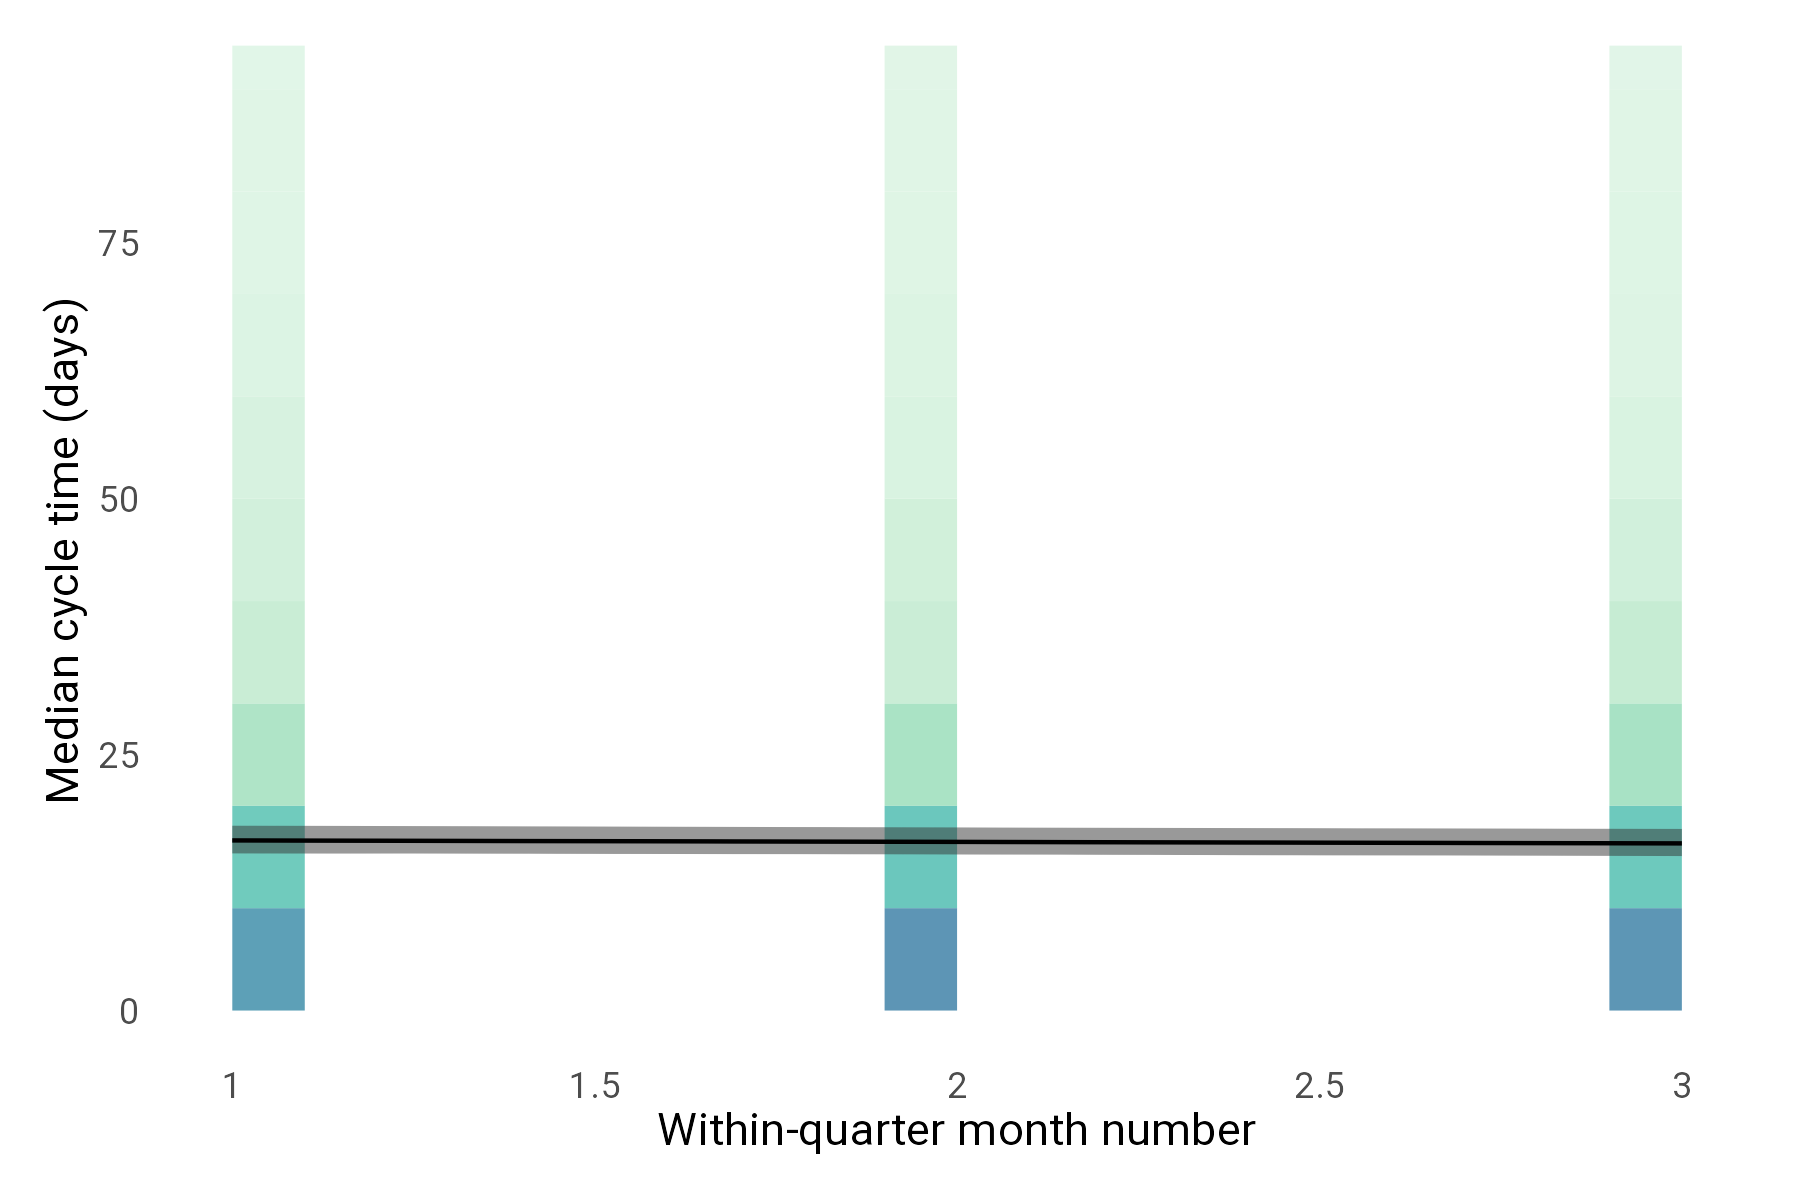{#fig-quarter }

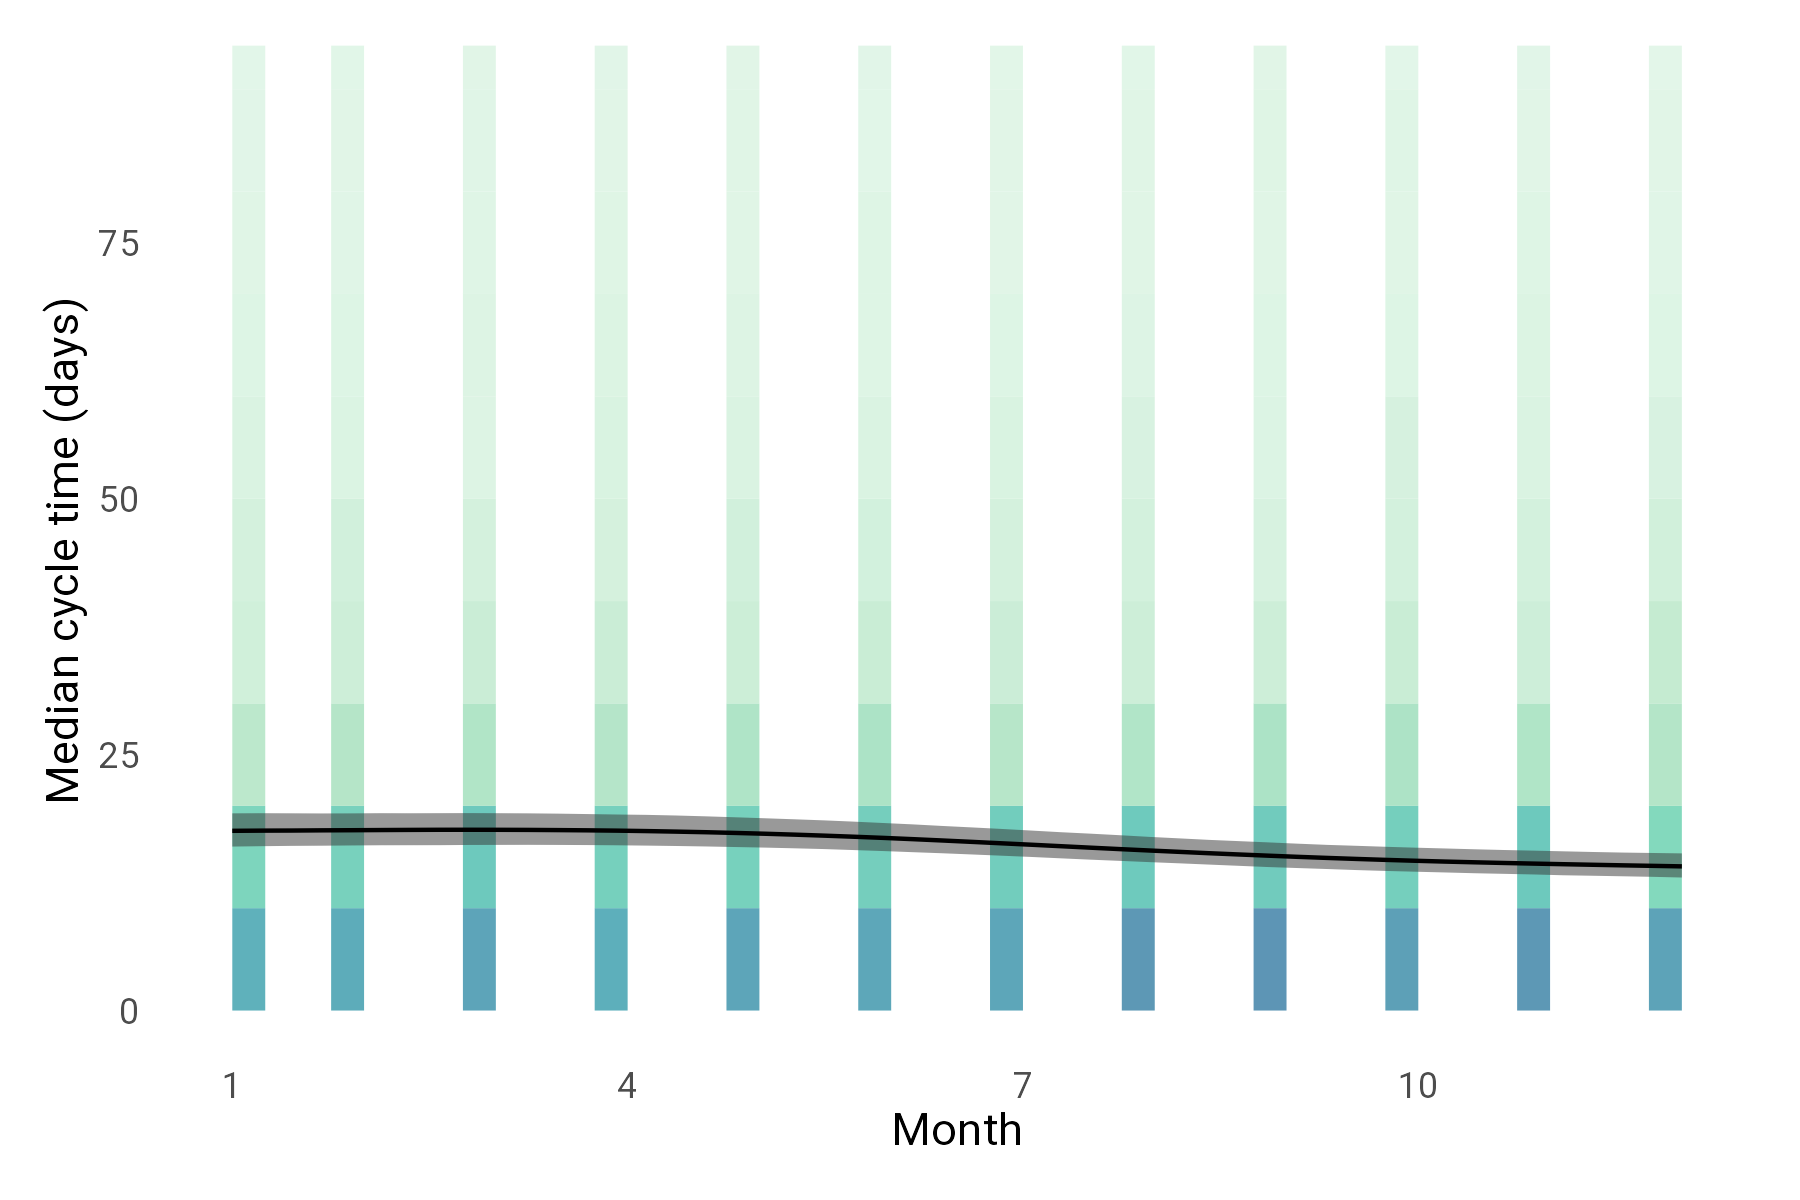{#fig-month }

Specifically, when individuals increased average coding days per week month-to-month they also tended to have lower cycle times, and individuals with more average coding days per week across the year tended to have lower cycle times (@fig-codingdays). The association between coding days and cycle time also tended to increase in strength across months, with 97% of the posterior in this direction.

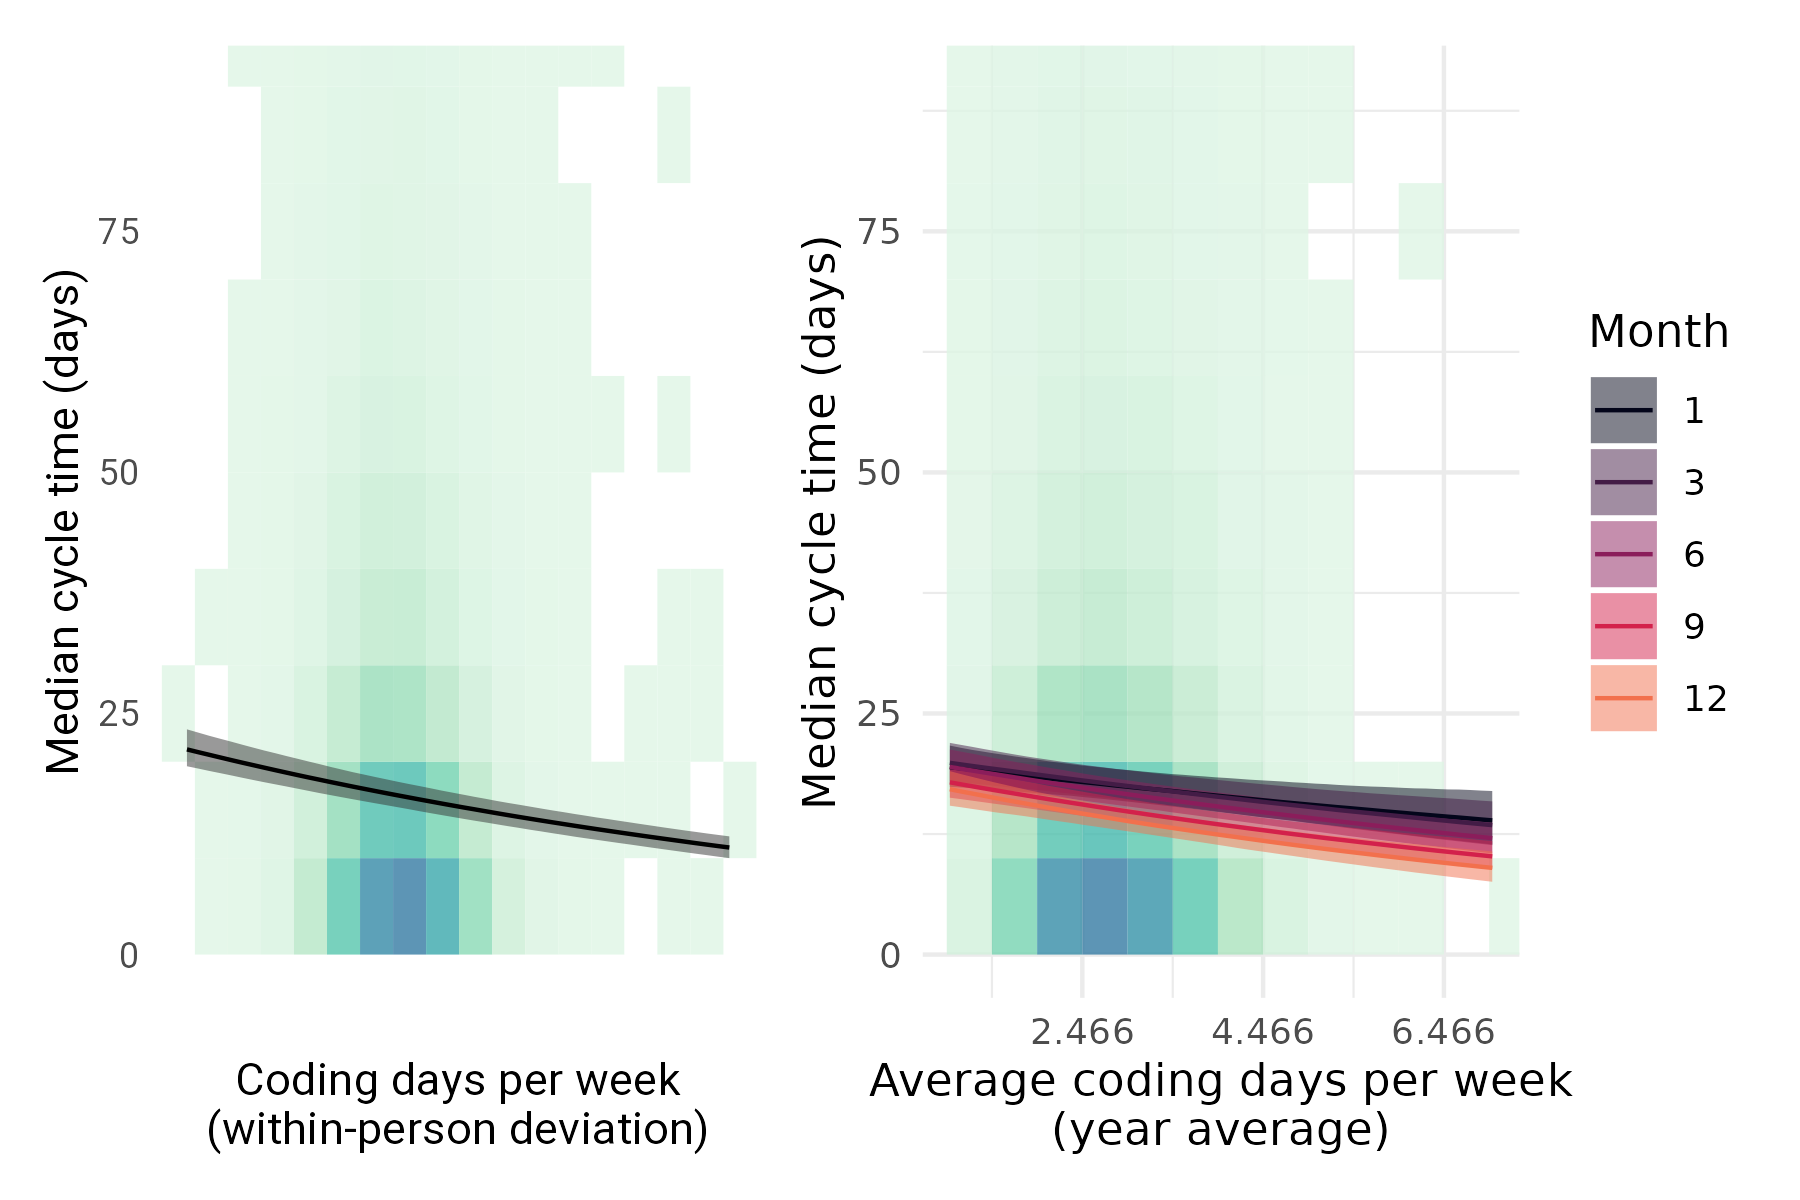{#fig-codingdays }

More merged PRs was associated with lower cycle time for both individual average differences and within-person differences. This effect also may get stronger across the year with 90% of the posterior in this direction (@fig-mergedprs).

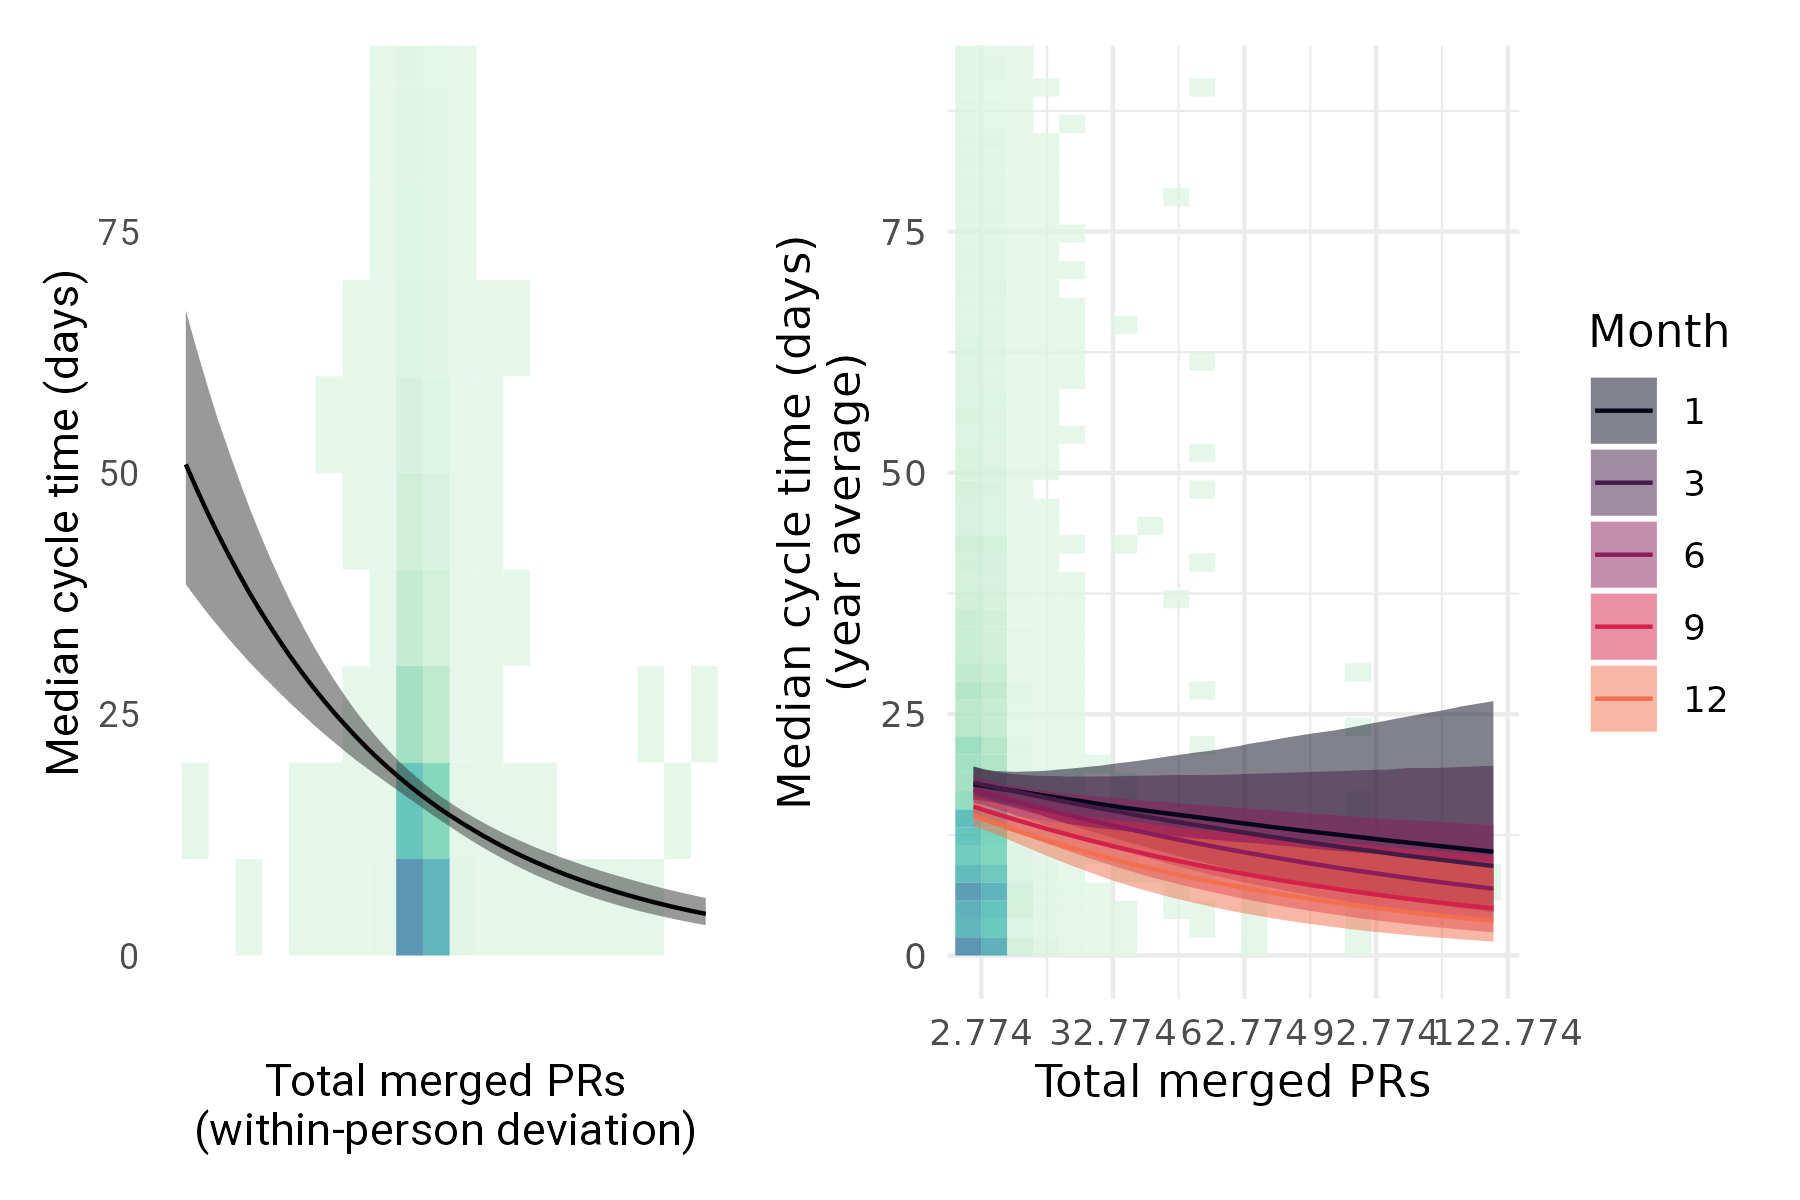{#fig-mergedprs }

The percent of defect tickets showed a negative association with cycle time for within-person deviations and a positive association for individual differences. In other words, individuals who tended to have more defect tickets as a proportion of their work across the course of the year also tended to have longer cycle times. However, for any given person, an increase in the proportion of defect tickets in a month was associated with lower cycle times (@fig-defecttickets). The interaction with month number for this effect was centered close to zero, with only 78% of the posterior in the negative direction with a fairly narrow distribution around zero (95% HDI = \[-0.0003, 0.0001\]).

![Higher-than-average proportion of defect tickets in a month is associated with shorter cycle times, while individuals with more defect tickets on average show longer cycle times. Background hexagons represent density of data, with darker colors indicating greater density. Lines are median posterior expectations, with 95% credible interval ribbons.](attachment:plots/cycle_time_full_intx_lin_remonth_defect_tickets.png){#fig-defecttickets }

Degree centrality, both on average across the year individual differences and within-person deviations, showed a negative association with cycle time (@fig-degree). In other words, individuals who on average contribute code to PRs that have a lot of other contributors tend to have lower cycle times for tickets they own. Similarly, when individuals’ collaboration on PRs increases in a given month, their cycle time tends to go down. This effect does not unambiguously strengthen or weaken across the year with 71% of the posterior for the interaction effect having negative sign with a fairly narrow distribution around zero (95% HDI = \[-0.0005, 0.0002\]).

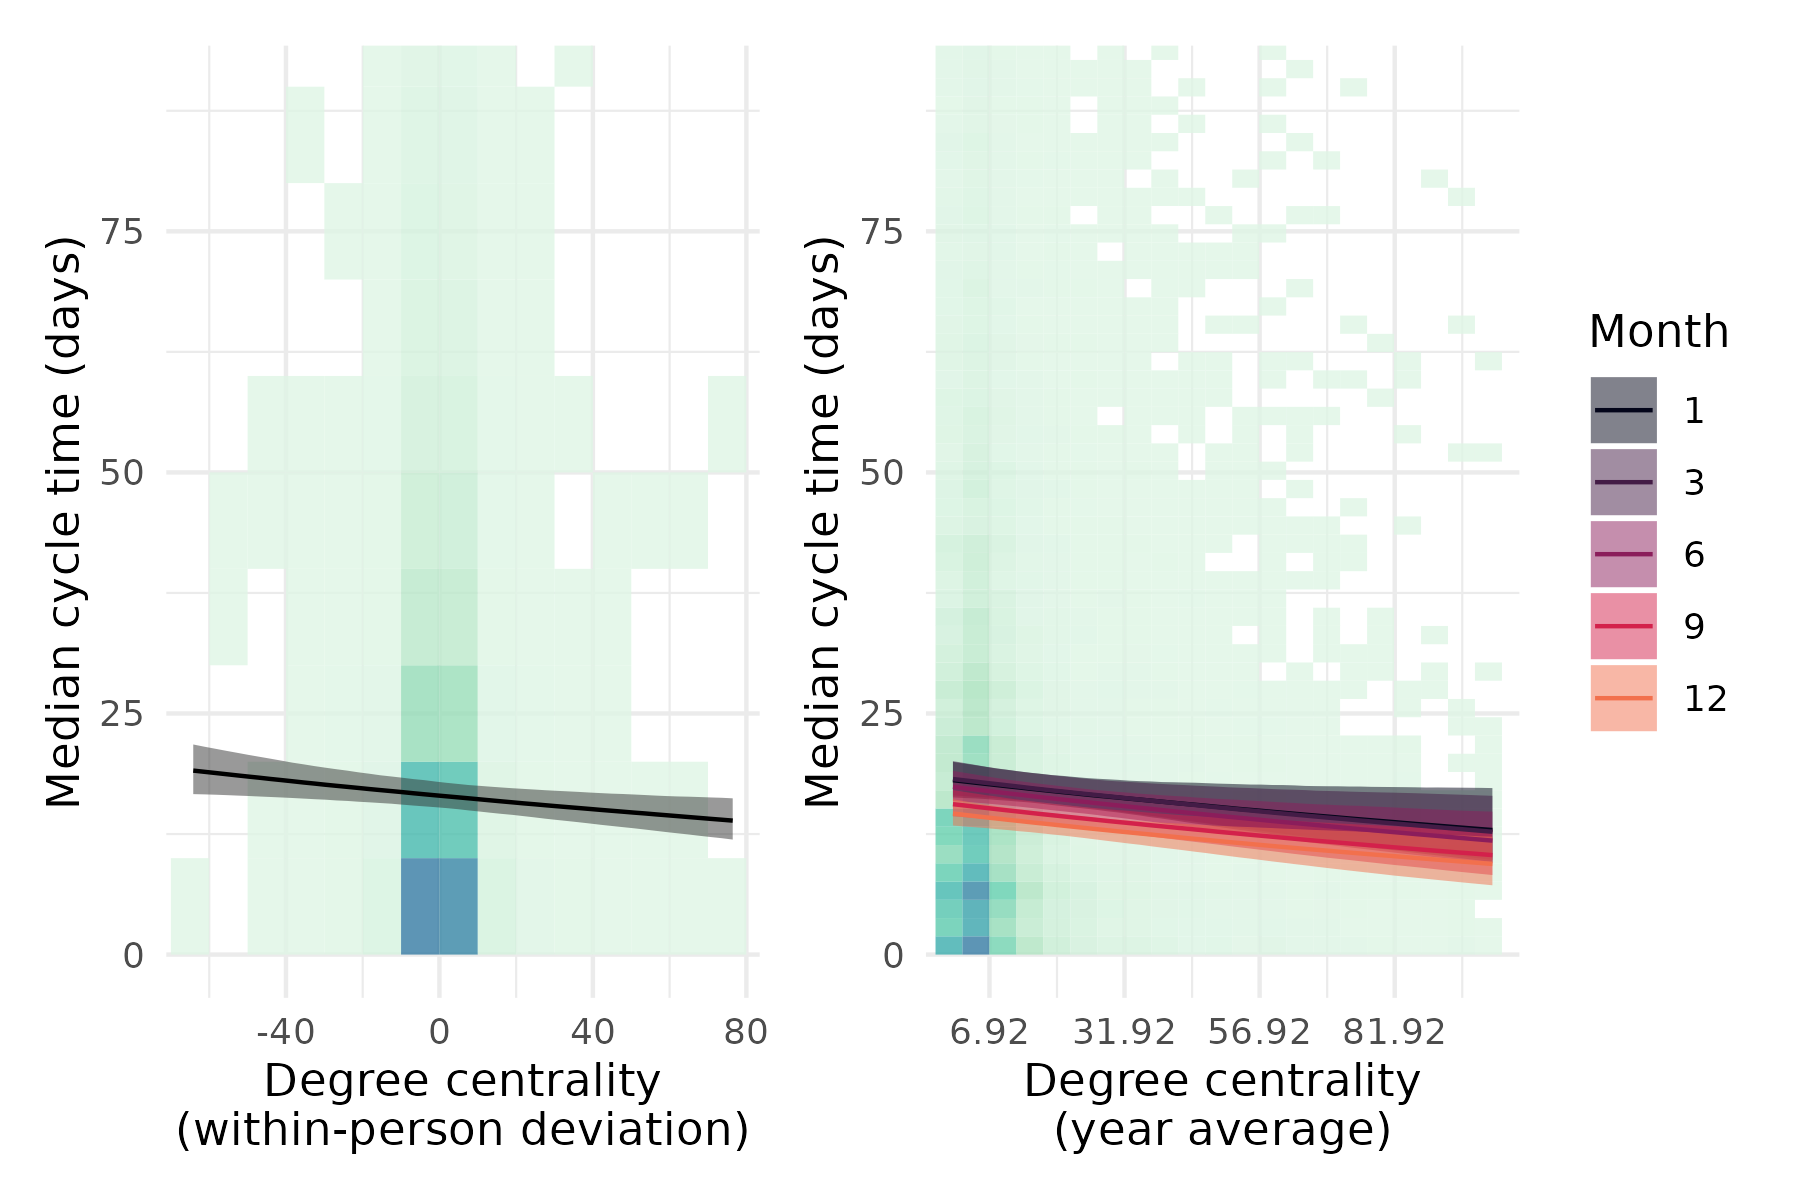{#fig-degree }

Finally, the number of comments per PR showed a positive association with cycle time. Individuals who tended to garner more comments on their PRs also tended to have higher cycle times, and within a given month, a higher number of comments per PR relative to a person’s average was also associated with higher cycle times (@fig-comments). This effect also does not unambiguously strengthen or weaken across the year with 59% of the posterior for the interaction effect having negative sign with a fairly narrow distribution around zero (95% HDI = \[-0.0004, 0.0005\]).

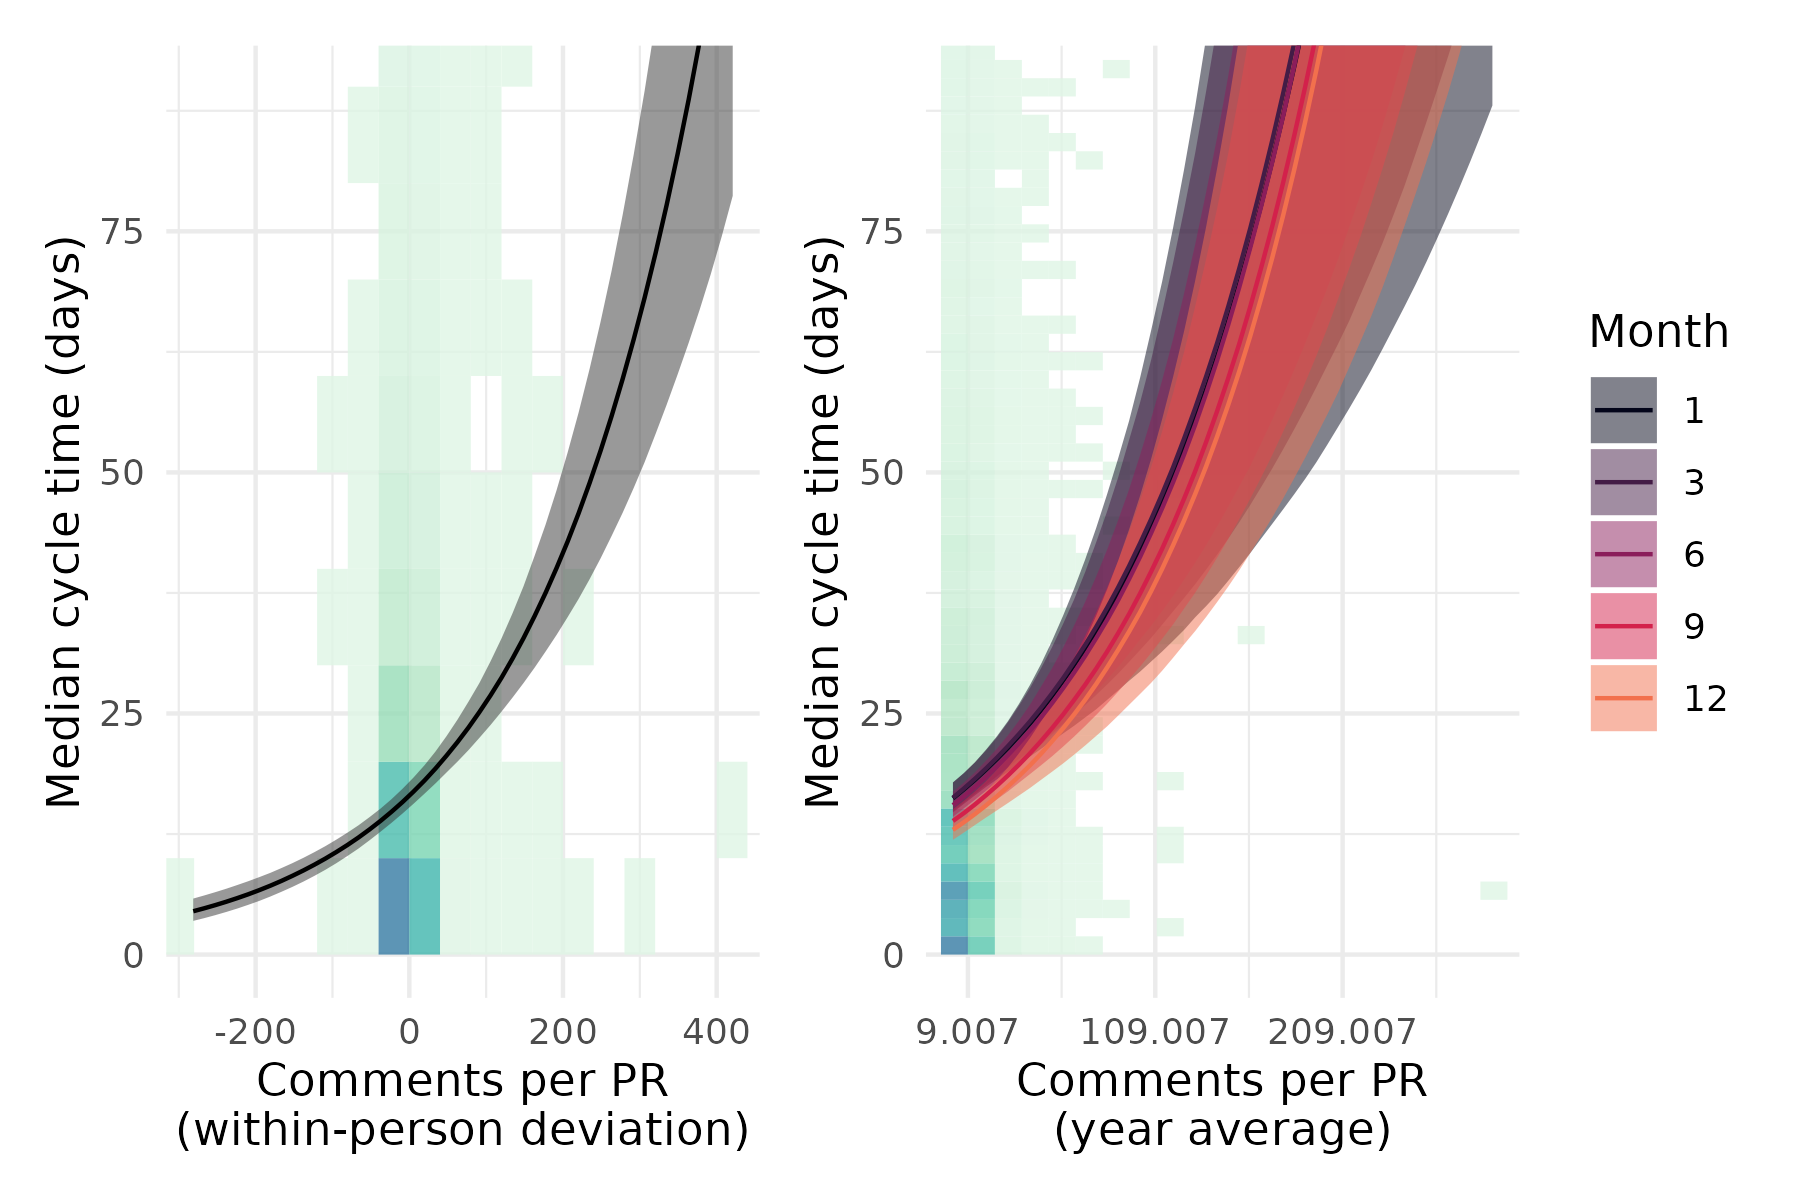{#fig-comments }

## Effect sizes and heterogeneity

Given the inherent non-linearity of the Weibull distribution, the effects of the predictors on cycle time are not constant across the range of the data. For example, the expected difference in cycle-time for a unit difference for within-person coding days per week will be different at different times of the year simply as a by-product that we are modeling the log of the scale parameter. Notice that this is true even in the absence of interactive effects, which further complicate the interpretation of the effect sizes for the year-average variables. Indeed, the random effects which allow intercept and month-effect variance both organizations and individuals also adds to the complexity of interpreting the effect sizes.

To give the reader a sense for how these associations play out across organizations, we plot a range of expected changes in cycle time given a counterfactual change from the 50th percentile to the 90th percentile on the variable of interest, all else held equal (@fig-heatmaps). We do this for each organization, for each month, and then plot these as a heatmap where the color represents the expected change in cycle time. This allows us to see how the effect of a variable on cycle time changes across organizations and across time.

<table style="width:100%;">
<colgroup>
<col style="width: 33%" />
<col style="width: 33%" />
<col style="width: 33%" />
</colgroup>
<tbody>
<tr class="odd">
<td style="text-align: left;"><div width="33.3%" data-layout-align="left">
<p>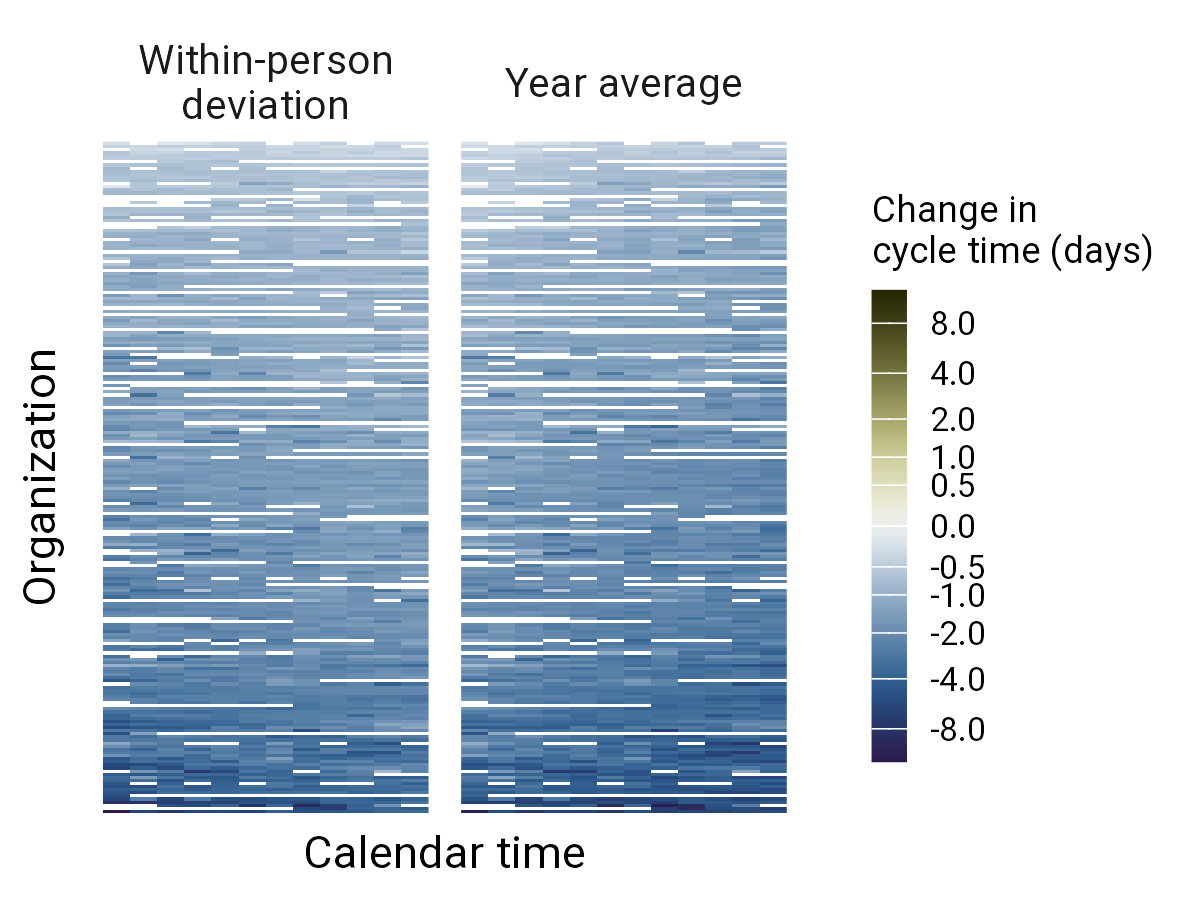</p>
</div></td>
<td style="text-align: left;"><div width="33.3%" data-layout-align="left">
<p>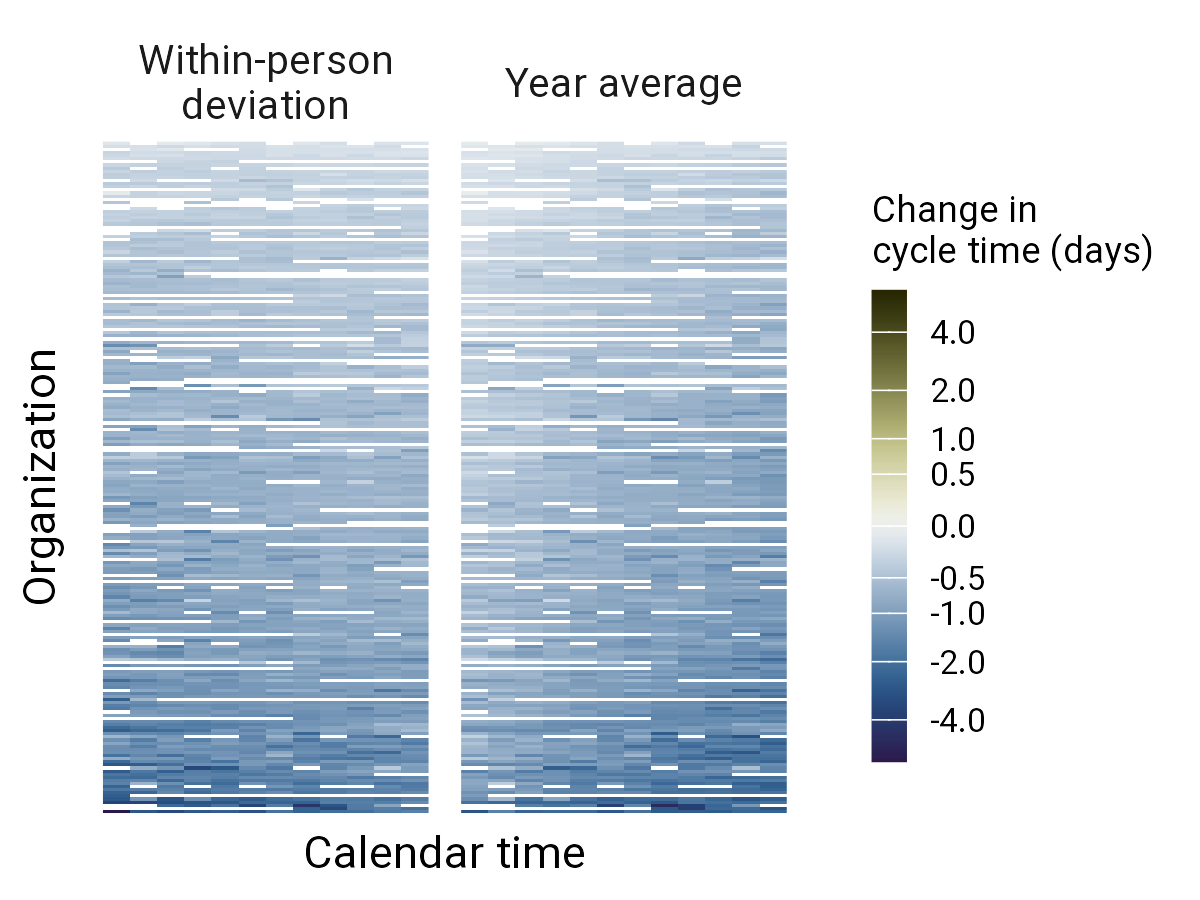</p>
</div></td>
<td style="text-align: left;"><div width="33.3%" data-layout-align="left">
<p>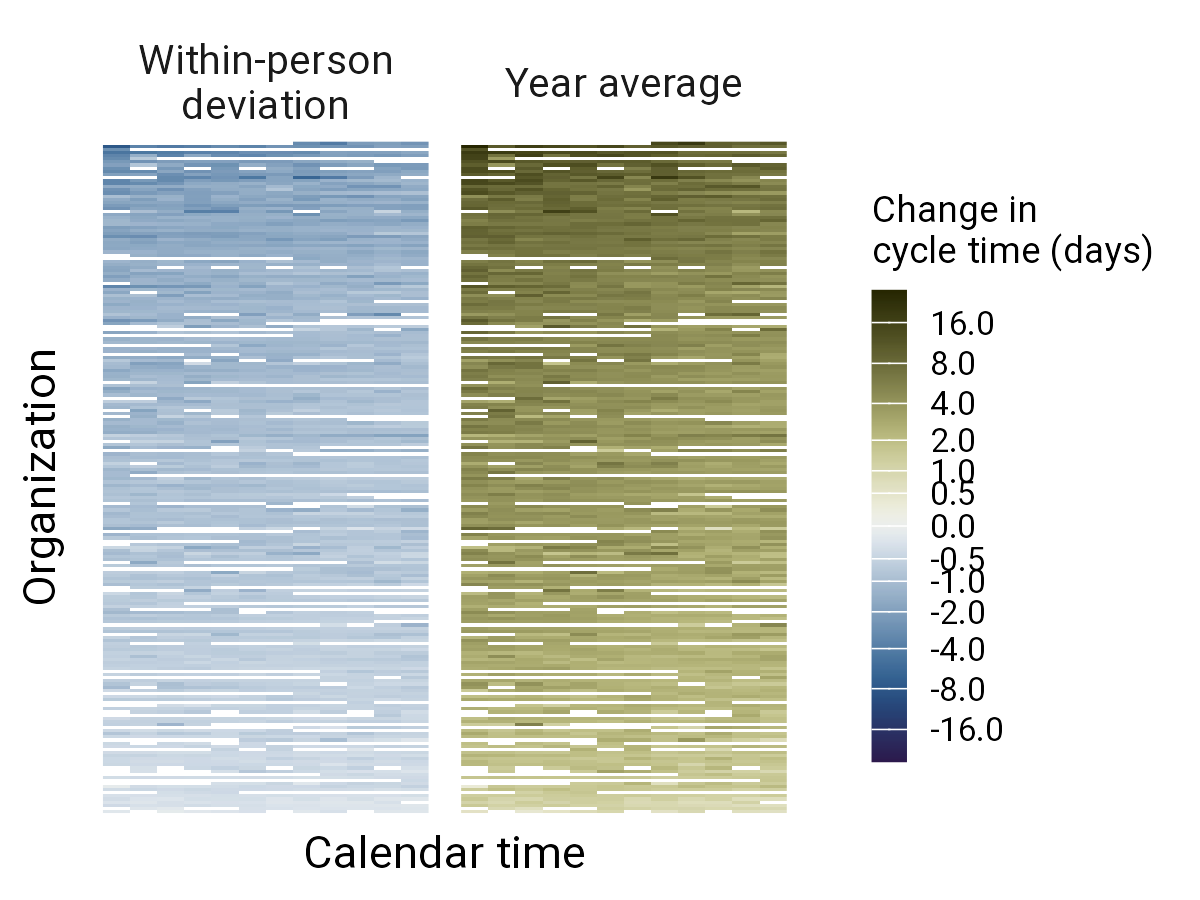</p>
</div></td>
</tr>
</tbody>
</table>

<table>
<colgroup>
<col style="width: 16%" />
<col style="width: 33%" />
<col style="width: 33%" />
<col style="width: 16%" />
</colgroup>
<tbody>
<tr class="odd">
<td style="text-align: left;"><div class="quarto-figure-spacer" width="16.6%" data-layout-align="left">
<p> </p>
</div></td>
<td style="text-align: left;"><div width="33.4%" data-layout-align="left">
<p>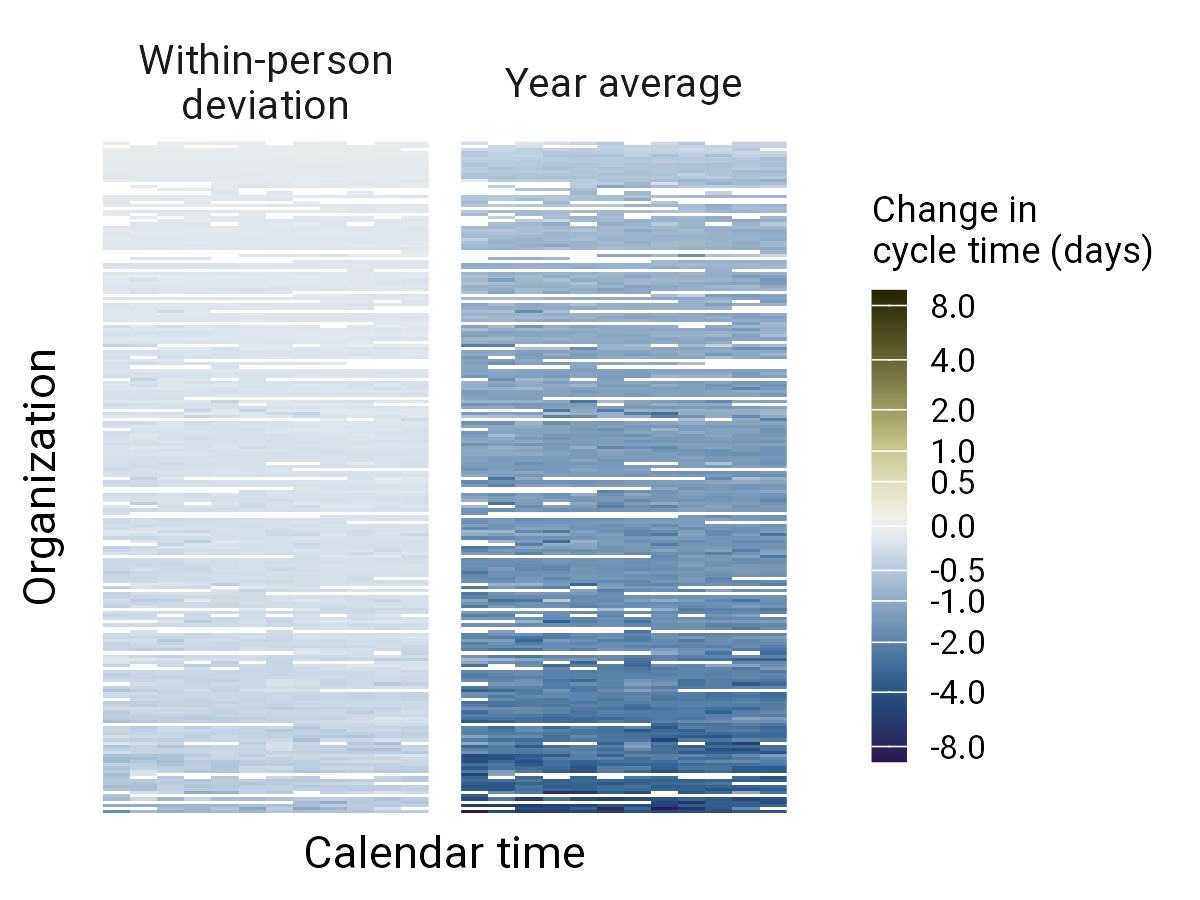</p>
</div></td>
<td style="text-align: left;"><div width="33.4%" data-layout-align="left">
<p>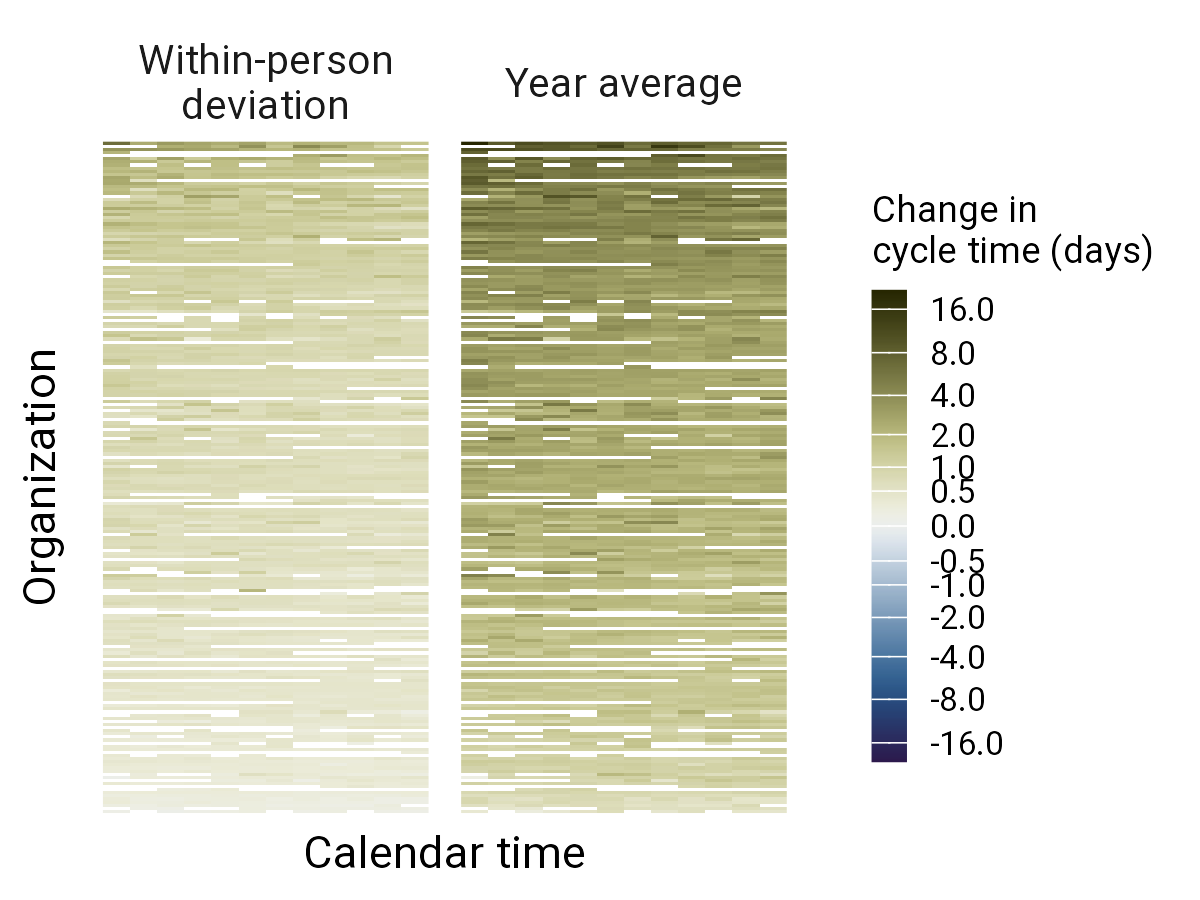</p>
</div></td>
<td style="text-align: left;"><div class="quarto-figure-spacer" width="16.6%" data-layout-align="left">
<p> </p>
</div></td>
</tr>
</tbody>
</table>

<table style="width:67%;">
<colgroup>
<col style="width: 16%" />
<col style="width: 33%" />
<col style="width: 16%" />
</colgroup>
<tbody>
<tr class="odd">
<td style="text-align: left;"><div class="quarto-figure-spacer" width="16.6%" data-layout-align="left">
<p> </p>
</div></td>
<td style="text-align: left;"><div width="33.4%" data-layout-align="left">
<p>Comments per PR</p>
</div></td>
<td style="text-align: left;"><div class="quarto-figure-spacer" width="16.6%" data-layout-align="left">
<p> </p>
</div></td>
</tr>
</tbody>
</table>

Effect sizes for each variable are heterogeneous across time, organizations, and values of other predictors. These plots show the expected change in cycle time from 50th to 90th percentile of each variable, by organization and month. The color represents the expected change in cycle time, with warm indicating an increase in cycle time and cool indicating a decrease. The scale is the same across all plots.

## Variability in effects

There is heterogeneity in the distribution of cycle time across organizations in both the scale and shape parameters, which suggests that comparisons of cycle time trends between teams across different organizations may be difficult and should include careful approaches that take into account this variation (@tbl-results-re). This can be seen visually as differences in the posterior predictive distribution of cycle times across organizations especially when viewed on a log scale to emphasize differences at the low end of cycle times where the distribution tends to be most dense (@fig-pp-check-org). Different organizations likely have different guidelines and cultures around using tickets and this may show up as this kind of heterogeneity in cycle time. Incidentally we can also see, looking across the full data-set, that the posterior distribution of our model captures well our data distribution (@fig-pp-check-sum).
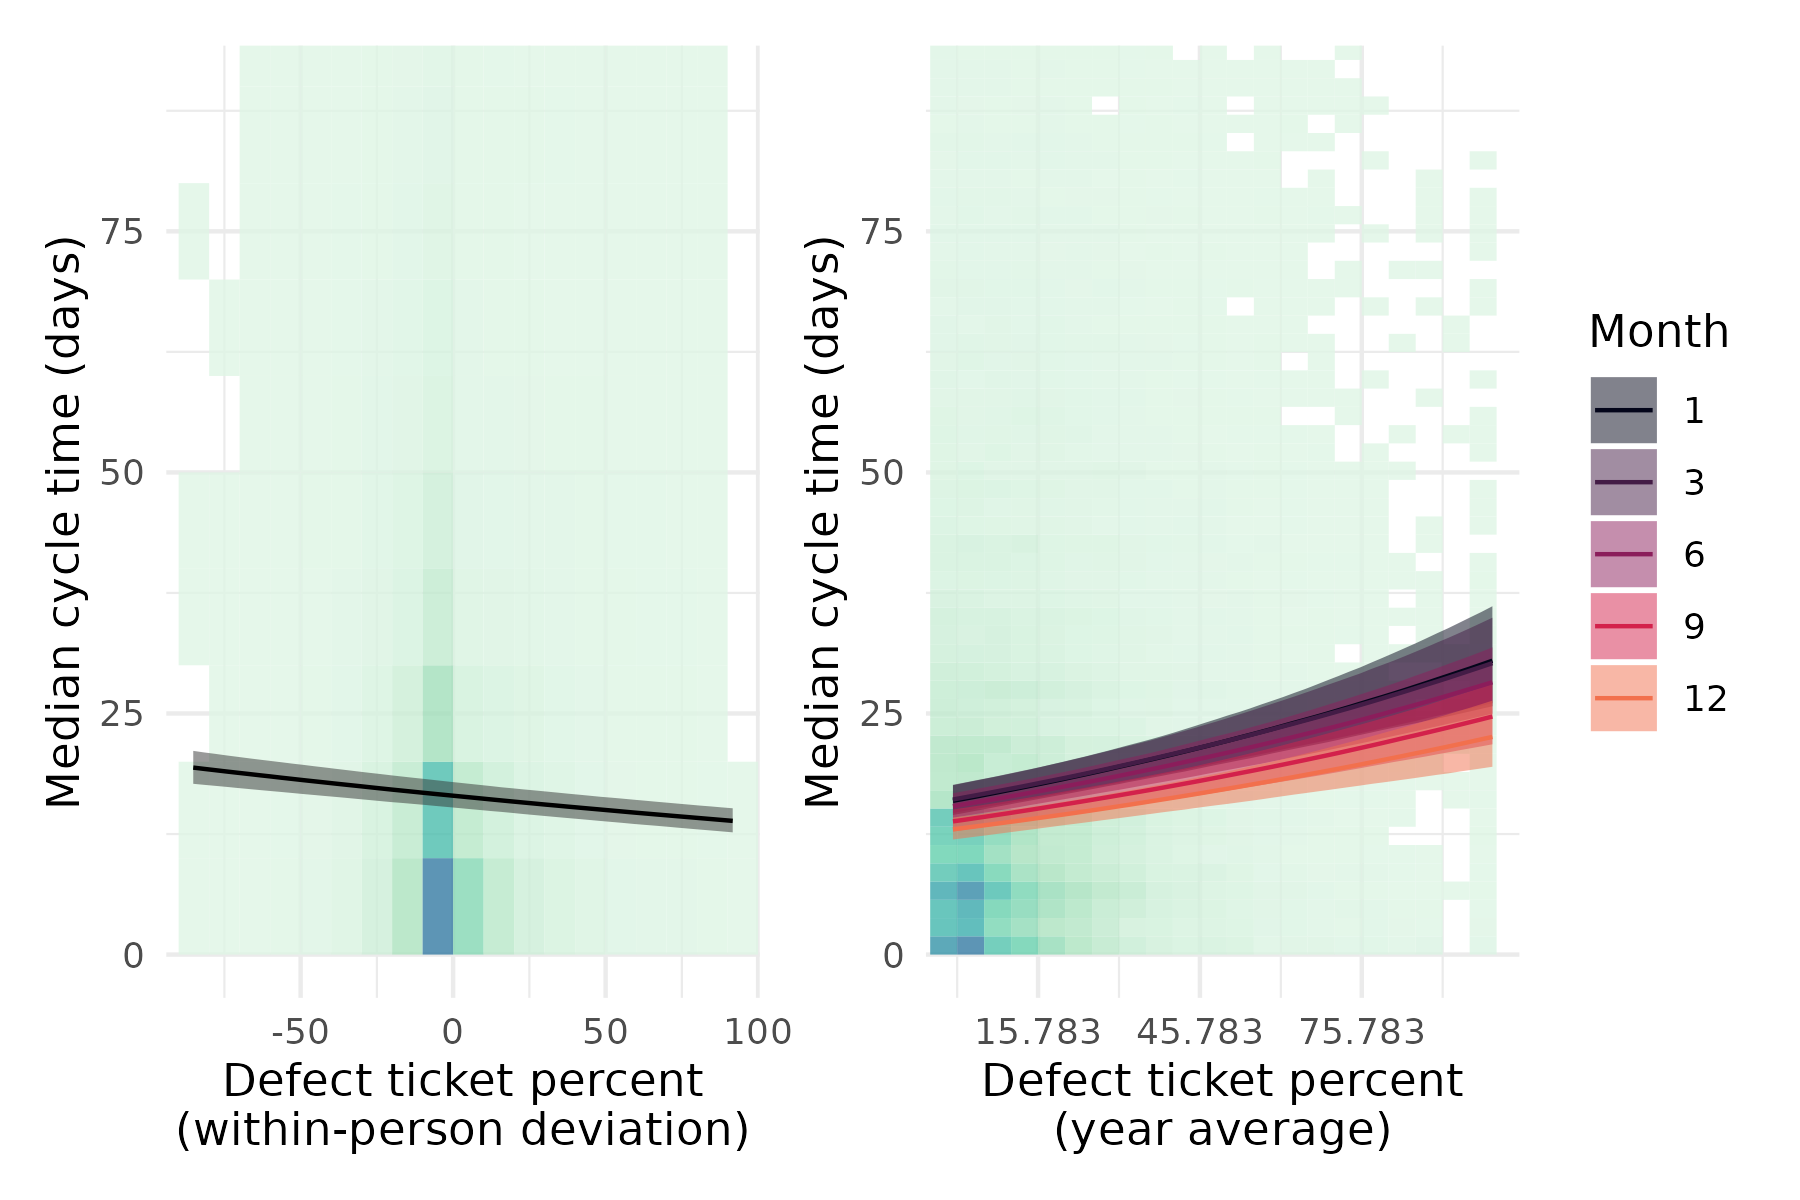

In [ ]:
ct_model_pars_dt <- as.data.table(ct_model_pars_re)

ct_model_pars_dt[, `:=`(
  Stat = fifelse(grepl("^sd_", Parameter), "SD", 
                     fifelse(grepl("^cor_", Parameter), "Correlation", NA_character_)),
  `Grouping` = fifelse(grepl("org_id_fac:user_id_fac", Parameter), "org:user", "org"),
  Par = fifelse(grepl('__shape_', Parameter), 'log(k)', 'log(\u03BB)'),
  Predictor = fifelse(
    grepl("^cor_", Parameter),
    "Intercept-Month",
    fifelse(grepl("month_num_c", Parameter), "Month", 
            fifelse(grepl("__(shape_)*Intercept", Parameter) & !grepl("__month_num_c", Parameter), "Intercept",
                    NA_character_)))
)]

ct_model_pars_dt[is.na(Par) & Predictor == "Month" & Stat == "SD", Parameter := "λ"]

setnames(ct_model_pars_dt, 
         c("Median", "CI_low", "CI_high", "pd"),
         c("Posterior Median", "Lower 95% HDI", "Upper 95% HDI", "Sign Probability"))

ct_model_pars_dt[, `Sign Probability` := paste0(round(`Sign Probability` * 100, 2), "%")]

setorder(ct_model_pars_dt, -Par, Grouping, -Stat, Predictor)

final_cols <- c("Par", "Grouping", "Stat", "Predictor",
                "Posterior Median", "Lower 95% HDI", "Upper 95% HDI", "Sign Probability")
display_dt <- ct_model_pars_dt[, ..final_cols]

flextable(display_dt) |>
  colformat_double(j = c("Posterior Median", "Lower 95% HDI", "Upper 95% HDI"), digits = 3) |>
  set_table_properties(layout = 'fixed', opts_pdf = list(float = 'float')) |>
  width(j = 1:3, .5, unit = 'in') |>
  width(j = 4, 1, unit = 'in') |>
  width(j = 5:8, .75, unit = 'in') |>
  theme_booktabs(bold_header = TRUE) |>
  align(j = 5:8, align = 'right', part = 'all') |> 
  merge_v(j = c("Par", 'Grouping', 'Stat')) |> 
  valign(j = c("Par", 'Grouping', 'Stat'), valign = "top") |> 
  footnote(
    i = 1, j = 1:5,
    value = as_paragraph(
      c('Response distribution parameter (λ: rate parameter, k: shape parameter)',
        'Grouping: Random effects grouping structure',
        'Parameter type (SD: standard deviation of random effect, Correlation: correlation between random effects)',
        'Fixed or random effect term',
        'Median of the posterior distribution, used as point estimate')
    ),
    ref_symbols = c('1', '2', '3', '4', '5'),
    part = 'header',
    inline = TRUE,
    sep = '. '
  ) |> 
  footnote(i = 1, j = 6:7,
           value = as_paragraph(
             '95% Highest Density Interval, containing the most probable parameter values with 95% posterior probability mass'
           ),
           part = 'header',
           inline = TRUE,
           sep = '. ',
           ref_symbols = '6'
  ) |> 
  footnote(i = 1, j = 8,
           value = as_paragraph(
               'Probability that the effect is in the reported direction, calculated as the proportion of posterior samples with the same sign as the point estimate'
             ),
           part = 'header',
           inline = TRUE,
           sep = '. ',
           ref_symbols = '7'
  ) |> 
  fontsize(size = 9, part = "all")

Par 1 Grouping 2 Stat 3 Predictor 4 Posterior Median 5 Lower 95% HDI 6 Upper 95% HDI 6 Sign Probability 7 log(λ) org SD Intercept 0.474 0.424 0.529 100% Month 0.034 0.027 0.042 100% Correlation Intercept-Month -0.123 -0.335 0.110 86.15% org:user SD Intercept 0.645 0.631 0.661 100% Month 0.067 0.062 0.071 100% Correlation Intercept-Month -0.131 -0.192 -0.077 100% log(k) org SD Intercept 0.277 0.247 0.310 100% 1 Response distribution parameter (λ: rate parameter, k: shape parameter) . 2 Grouping: Random effects grouping structure . 3 Parameter type (SD: standard deviation of random effect, Correlation: correlation between random effects) . 4 Fixed or random effect term . 5 Median of the posterior distribution, used as point estimate . 6 95% Highest Density Interval, containing the most probable parameter values with 95% posterior probability mass . 7 Probability that the effect is in the reported direction, calculated as the proportion of posterior samples with the same sign as the point estimate .

![Distributions of cycle time vary widely across organizations both in their central tendency and spread. Posterior prediction densities for model-expected distributions of cycle time are shown across all organizations with at least 10 observations. Each density represents one organization, showing model-predicted cycle times from 50 posterior draws. The scale has been transformed slightly to better show the spread of data. Columns have been ordered by sample size, and rows are ordered by median predicted cycle time. Density fill colors reflect sample size. Note that distributions from larger orgs have less variability in their posterior predictions. Line at 4 weeks is set arbitrarily to aid in comparisons.](attachment:plots/cycle_time_full_intx_nlq_pp_check.png){#fig-pp-check-org }

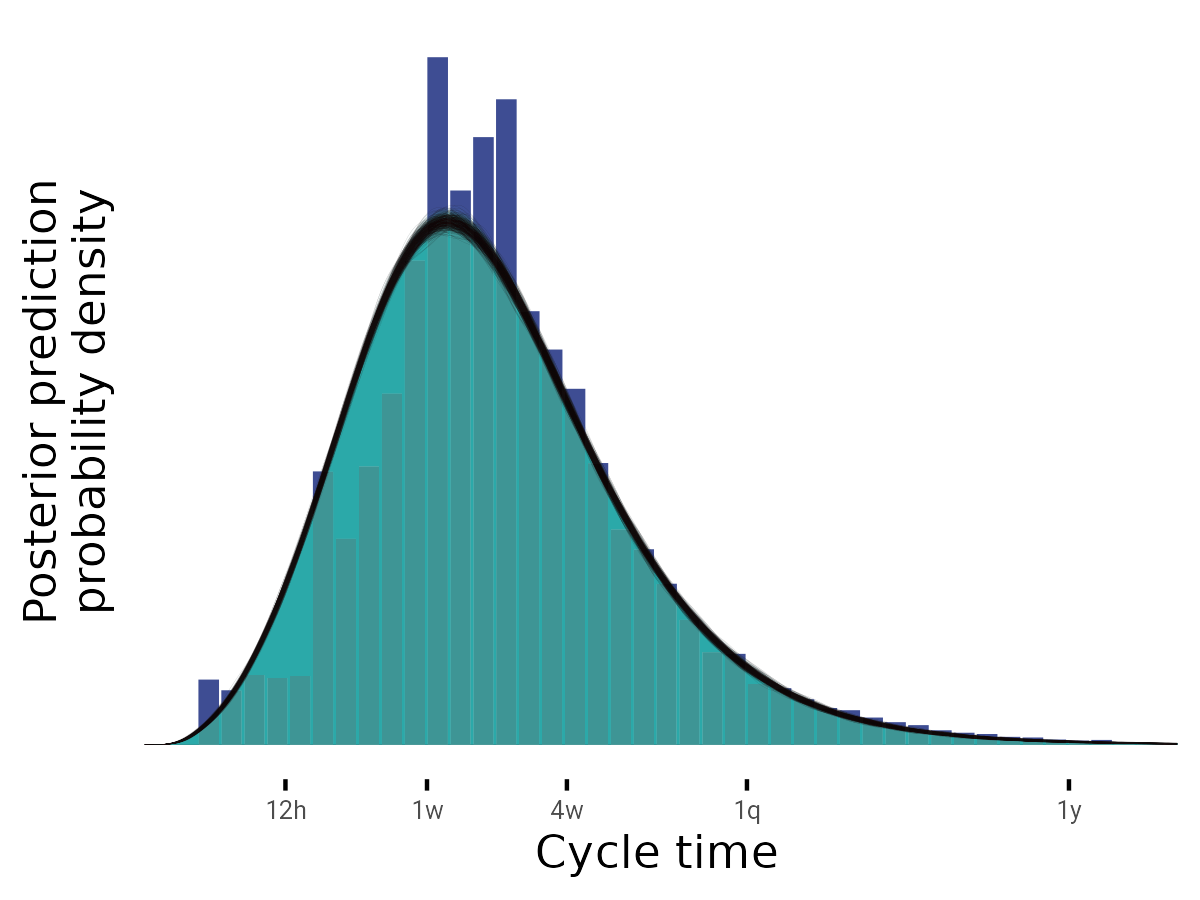{#fig-pp-check-sum }

Variation across individuals’ scale parameter after accounting for organization heterogeneity is also substantial, and greater in magnitude than organizational heterogeneity (sd = 0.65 \[0.63, 0.66\] versus sd = 0.47 \[0.42, 0.53\]; @tbl-results-re). There is also notable heterogeneity in the effect of month both at the organization level and the level of individuals. There is a small negative correlation between individuals’ (and less credibly, organizations’) scale intercepts and the effect of month meaning that a person who has a higher cycle time at month 7 also tends to decrease more steeply in their cycle time across the year (@tbl-results-re).

We also examine the variability around our population effects. @fig-bw-ct-traj shows model-expected cycle-time trajectories across the year for randomly-sampled individuals. One of the stronger effects at the population-level is the effect of the average number of coding-days-per-week (both averaged over the year, and month by month). To begin, we examine the effect of year-average coding-days-per-week. We split the sampled individuals into 5%-wide quantiles based on their yearly average coding days per week. The population-level effect discussed above reveals that, on average, individuals who have more coding-days-per-week also tend to have lower cycle times. This shows up subtly in Figure 9 as a decline in cycle-time from left-to-right across these quantiles, especially when examining the amount to which the trajectories occur below the thick black median-cycle-time line.

![Individual observations of cycle time are highly variable across the year. Each line tracks cycle time month-to-month for one randomly sampled individual. Each facet shows the trajectories for individuals who have year-average average-coding-days-per-week in the quantile specified at the top of the facet. Shading represents prediction intervals from the model for plausible cycle time values for these individuals.](attachment:plots/cycle_time_full_intx_lin_remonth_post_pred_ids.png){#fig-bw-ct-traj }

What is important about this illustration when interpreting these results in the context of a real software development team is that it shows a single measurement for a person on any given day or even averaged across a month may not be representative of that individual’s long-term trend. While some of this uncertainty reflects measurement error, much of it is irreducible given the factors we’ve considered in this analysis. It may be possible to reduce it by adding further information to the model. However, at present the conclusion must be that one must take great care in comparing cycle-time between individuals even in the same organization, or even against themselves.

We can also examine the effect of month-by-month deviations in coding-days-per-week at the level of these example individuals. @fig-wi-ct-traj shows data for the same quantiles as above, but now cycle time is normalized around each person’s median to better visualize within-person deviations in cycle time. Again, across the year we see that variation within-person is substantial. While we can see the tendency for within-person increases and decreases in average-coding-days-per-week to affect cycle time, there is considerable variation still, with many yellow-colored points above the 0 line and darker points below the zero line.

![Individual month-to-month deviations from year-average cycle time are highly variable across the year. Each line tracks cycle time month-to-month for one randomly sampled individual. Each facet shows the trajectories for individuals who have year-average average-coding-days-per-week in the quantile specified at the top of the facet. Shading represents prediction intervals from the model for plausible cycle time values for these individuals.](attachment:plots/cycle_time_full_intx_nlq_post_pred_ids_win.png){#fig-wi-ct-traj }

We can unpack this variability further with the help of our model. We will again examine a random subset of 10 participants with complete data across the year. Again, each one is sampled from a different bin of values of one of our strongest predictors, year-average average-coding-days-per-week. @fig-ct-pp-traj (left) shows the model-expected central tendency (gloss as a sort of moving-average) of each of these participants, along with their observed data. We can also ask the model to generate plausible values for cycle time that we might observe; these are the gray lines behind everything. What is clear here is that there is some systematic effect on the central tendency for different levels of year-average coding days. Again, we see a lot of overlap across individuals. And when we examine both the observed data, and the model predictions, we see a whole lot more overlap.

The next thing we can do with the model is ask it to give us these expectations and predictions under the counterfactual condition of each of these participants having a different number of year-average coding days. This is just a simulation, not an experiment, so we should heed this caveat. In @fig-ct-pp-traj (right), we see model expectations and posterior predictions were each of these participants induced to take on the yearly-average number of coding days from the 10th, 50th, and 90th quantile of our data. This is a huge spread, but we see only small, incremental changes in the model expectations for each of them. More importantly, the spread of the posterior predictions, binned for ease of visualization in the pixels behind the expectation lines, are nearly indistinguishable. Taken together, these results once again suggest caution in the use of this highly variable software metric: taking a relatively unsophisticated monthly average of an individual developer’s cycle time data is not likely to be able to tell you what their cycle time will be like in the future. This further suggests that future work investigating the impact of interventions on factors that impact cycle time may expect to see relatively small or even invisible changes at the individual level, even when inducing changes that do scale to desired impact at the organizational level.

![Variability in cycle time within-person across time overwhelms subtle differences in averages. These plots show posterior predictions of reasonable monthly-median cycle time and counterfactual predictions. The **left** plot shows model expectations (our best guess at the central tendency) and 95% credible intervals (colored lines and ribbons) of cycle time over the year for 10 randomly selected participants. Lines and ribbons are colored by the participants observed year-average average-coding-days-per-week. Black points and the stronger black line indicates observed data for these participants. Light gray lines represent model-derived posterior predictions of cycle times we might expect to see from these participants. The **right** plot shows these same participants under three counterfactual conditions: with their year-average-coding-days set to the 10th, 50th, and 90th quantile values. Each line represents the model expectation under these conditions, all else being equal. Posterior predictions of reasonable values for observed median-monthly cycle times are binned by these quantiles and by month in the pixels behind the expectations.](attachment:plots/cycle_time_full_intx_nlq_combined_post_pred_counterfactual.png){#fig-ct-pp-traj }

# Limitations

Throughout the results, we have included commentary on the larger context of software work and associated cautions regarding the interpretation of our findings. In the following discussion section, we further elaborate on future research directions which may build on the evidence in the current paper. As noted in the introduction, there are many limitations to the usage of an output-based velocity metric, including that such a metric does not capture business outcomes, the quality of task performance, and perceived value of software development work. Nevertheless, monitoring cycle time is frequently recommended as a measurement practice for software management. Below, we elaborate on four key limitations of the current findings in greater detail, which are of course also opportunities for future research.

First, measurement validity challenges in ticket data and sample representativeness constrain our analysis. A primary contribution of this paper is to present findings from the analysis of a large (more than 55k observations across 216 organizations) and longitudinal (a calendar year) dataset of software work activity data. Metrics which are git-based can enhance the measurement validity of our project by providing this large-scale observation, unfiltered by individual perception, in the ecologically valid context of real working teams. Nevertheless, measurement validity may also be threatened by the way that data are defined and constructed in the process leading to the creation of variables around tickets: for instance, we rely on a general assumption that teams mark tickets in a fairly accurate and timely manner. Our dataset lacked contextual information that could serve to validate team practices around ticket entry, and while we sought to align our assumptions with known practices around these ticketing tools and software workflows, it is important to note that differences in the timeliness and accuracy of ticket entries may be an important factor complicating our ability to understand cycle time. This context limitation also applies to our sample of organizations which is non-random and reflects organizations that invested in the software metrics tool that provided that data.

Second, systematic differences in ticket assignment patterns may complicate cycle time interpretations. In this analysis, we have primarily explored cycle time as derived from a tickets-based metric. However, how a ticket and its associated work tasks are assigned inside of an organization is likely an important factor in how tickets are completed. Assignment of tickets, especially defect tickets, is complex over time and both the initial and subsequent assignments of tickets can be impacted by many factors. For example, after an initial assignment to a developer, bugs may frequently be reassigned due to diverse factors such as determining ownership, time constraints, and identifying developers who may have a particular view into the root cause of the bug \[@guoNotMyBug2011\]. Some individuals may get assigned defect tickets systematically more often than others, and changes in the proportion of work that consists of defect tickets may change how fast someone is able to work in general, either because defect tickets tend to be larger or smaller in scope than other tickets, or because of disruptions.

Third, our simplified measurement of team structures fails to capture the complex collaborative reality of software development. In this analysis, given limitations in our dataset about contexts such as internal team structures within organizations, we have explored team size with a generous attribution of team belonging across shared activity, which almost certainly represents a very rough estimate of team size. We have also calculated team size as averaged in a static measure for the entire year, rather than captured over time. Given that team size likely impacts how quickly work is completed, we may miss out on nuanced effects here; for instance, it is reasonable to imagine that further variables around how resources are distributed and allocated to teams may provide further predictive value to our understanding of team-level factors that change cycle time. Team “assignment” itself is also highly complex in technical work, as cross-team collaboration is typical, and collaborations across software projects may frequently not match explicit organizational hierarchies. In our previous research using self-reports from software teams, we have found that over 60% of individual contributors on software teams report working closely with other individual collaborators who do not share their same manager \[@hicksDeveloperThrivingFour2023\]. In short, software development is a collaborative exercise that is embedded in an ecosystem with history and many actors \[@hicksCumulativeCultureTheory2024\].

Fourth, invisible collaborative activities and contributor role ambiguity limit interpretations of cycle time variations. Developers communicate and collaborate in many ways that may not be captured in a ticket, e.g. impromptu or formal mentorship, paired or mob programming, and planning meetings. Where activity data are collected for some of these activities, it is likely that such data may be perceived in our data collection as “belonging” to a single individual, but work may often reflect joint work (e.g., in the case of mentorship, paired, and planning activities where one developers “logs” the work of many). These organizational communication activities and social norms may provide informative context for interpreting cycle time activities. For instance, organizational planning data may provide a useful next step in understanding how planning meetings do or do not cause downstream cycle time to progress more efficiently. Also many people that work on software may not be represented in this ticketing data. We also do not know for certain the job titles of each contributor to this dataset and use the term software developer broadly.

# Discussion

## Take-aways for practitioners and Anti Patterns

In this section, we summarize parts of our more thorough discussion (below) in plain language that we hope will be useful for software practitioners, highlighting not only the evidence at hand, but also cautionary anti-patterns we think may be likely when using cycle time data at scale.

-   We observe many robust influences on cycle time but with small effects. This means implementing a change targeting any one of these factors may help a little bit, but don’t expect a magic bullet. We recommend that practitioners consider the trade-offs of implementing any particular change by incorporating more context about developers’ work tasks that goes beyond activity data, as well as designing an iterative, experimental approach to evaluating changes that includes measures that go beyond cycle time, such as incorporating developers’ self-report on the utility of measurement practices.
-   Any single observation of cycle time is a very noisy indication of what is typical. Again, remember that each ticket’s time-to-close is influenced by myriad factors, most of which are beyond the individual contributor’s control. Ensuring a standard and repeatable practice around how tickets are created and managed across teams may also be a necessary precondition to relying on ticket data to make valid comparisons.
-   Practitioners can use this research to feel justified in seeking more shared and environmental explanations for the speed of work while doing complex software development, rather than locating their explanations in individual blame, or praise.
-   We can start to build up a sense of cycle times for teams and individuals if we are willing to observe patiently over long periods of time. Since we rarely observe identical task repetition, we need more observations to establish “typical” performance and identify factors that influence cycle time. Similar to public health research, understanding software work requires studying diverse contexts across industries and companies. This broad scope also creates opportunities for natural experiments. While organizations may hesitate to share data, these “secrets” typically diffuse naturally, and free revealing may ultimately prove more profitable, as described by @vonhippelFreeRevealingPrivatecollective2006.
-   We should understand that cycle time is still quite distant from the ultimate objective: efficient delivery of value in a context that supports those who produce that value.
-   Although we did not have self-report data from individual contributors in the context of this analysis, it is possible that their perceptions and experience of doing software work gives them an accurate sense of what can help or hinder their problem solving. The measurement and attempt to change any particular objective indicator of software work, such as cycle time, should happen in conversation with these experts.
-   If you collect your own data on this, be aware that sometimes data can be too noisy to draw any credible conclusions. That in itself is a signal you can use to improve how and what you measure. At the end of the day, software development problem-solving is a social, human activity, and these are notoriously complex.

## General Discussion

Our analyses revealed precise directional associations between the factors of interest and cycle time, though the magnitude of these effects warrants careful consideration. These effects were generally in an intuitive direction for coding time, task scoping, and collaboration. More coding days, both on average across the year (between-person), and month-to-month variations from that average (within-person) was associated with lower cycle times. Moreover, the effect of average coding days on cycle-time had a larger effect later in the year. Having more merged PRs both on average, and month-to-month was also associated with lower cycle-time. Greater collaboration at both the between- and within-person level, and as measured by shared work on the same pull request (and operationalized as degree centrality), were associated with lower cycle-times as well. Two main results will require more nuance in their interpretation. The effect of task scoping as measured by defect tickets (where a lower percentage of defect tickets, representing unplanned work, was taken as better task scoping) was associated with faster cycle times at the within-person level and greater cycle times at the between-person level. Finally, collaboration as measured by comments-per-PR was associated with longer cycle times. These main effects, while quite precise, were also somewhat small, and are set against a backdrop of substantial unexplained between- and within-person variation. This suggests that while there are a number of factors that do push around cycle-time, each the life cycle of each ticket is a complex function that is not necessarily captured by the metrics we have available, some of which are quite commonly recommended as important inputs to cycle time.

It is perhaps not surprising that cycle time benefits when individuals have more time to code, either as a deviation from their usual, or than other people doing similar work. When task completion requires writing code, more time to code will obviously decrease time until completion. Similarly, being able to break work into more discrete chunks and completing more of these chunks should also benefit cycle time. Keep in mind that these results both control for the other. That is, this is the effect of more PRs for the same amount of coding time, and vice versa (we discuss this benefit of our modeling approach more below).

Perhaps not as obviously, contributing code to a PR that is being contributed by others (what is captured by our degree centrality measure) also benefits cycle time. Contrary to the possibility that there are too many cooks in the kitchen, we show that on average cycle time is lower when people work together on a shared problem. Again, this is all-else-equal controlling for coding time, total PRs, and the other variables in our model. However, we must also consider that more comments per PR is associated with higher cycle time. This is another signal of coordination and collaboration, but has an opposite effect. Although speculative, we think that this reflects cases where a particular PR is attempting to solve a difficult problem, and where discussion is needed. Of course, this may also be a signal that communication can sometimes become problematic. Future work would have to examine the content of the PR and communication to disambiguate these possibilities as well as others.

To finish our preliminary discussion of the main effects, we consider the effect of defect tickets. Individuals with a higher proportion of defect tickets on average over the course of the year tend to also have longer cycle times, while a person who suddenly has more defect tickets in a given month tends to have lower cycle times that month. We speculate that the between-person effect may be a result of different roles: in other words, people whose general workload is bug squashing may simply be given more difficult bugs to squash; alternatively, if less experienced programmers are generally given more bugs as a share of work, they may be slower at completing their tasks. Organizational factors may also be a culprit: if one’s work is, on average over the course of a year, swamped by defect tickets, one doesn’t have time to complete other tasks.

Considering the association of lower cycle-times during months when a person tends to have more defect tickets, we speculate that this may be a result of a shift in work from larger pieces of generative work to fixing a lot of small errors. Again, as is the case with the between-person effect here, and with the effect of comments per PR above, these results suggest that a holistic and diagnostic approach to understanding cycle time changes and their relationship to tickets would need to include measures of the content of tickets (and context around ticket assignment) in a more granular way than was possible within the scope of this project.

The substantial individual differences observed in our analysis, coupled with considerable residual variance after accounting for all measured factors, presents both methodological and practical implications for the assessment of software work. This heterogeneity in software metrics suggests that detecting the impact of specific interventions on cycle time may prove challenging unless the effect size substantially exceeds the natural variation in individual and team performance. The magnitude of unexplained variance serves as a crucial caveat for practitioners and researchers attempting to implement and evaluate software work interventions in software development contexts.

The observed variability itself constitutes a meaningful signal that resonates with the lived experience of software development practitioners. Our findings suggest that there exists no universal formula for optimizing cycle time or enhancing software work across all contexts and individuals. Rather, the path toward improved development efficiency likely requires a nuanced approach that acknowledges this inherent variability while simultaneously pursuing refined measurement methodologies and targeted interventions. Success in this domain may depend on our ability to identify and mitigate confounding factors while developing increasingly sophisticated metrics that capture the complexity of software development processes.

Indeed, the amount of variability apparent in these ticket data is likely the result of the complexity of each unit of work in software development. The process of setting a particular goal, and then of planning how to reach that goal by breaking the work into discrete tickets and tasks, is itself both conceptually and socially complex, and may impact cycle-time. Moreover, the preconditions set by previous work on a codebase determines what a software developer is able to do to reach a particular goal and close a ticket. The discussion of the process of ticket assignment in the limitations, above, is also relevant here. Though crucially important as inputs to software work, these sources of variability are not often measured and may be considered by some to be immeasurable.

This work shows some clear signals about what might get in the way of closing tickets. Developers may lack enough time for coding, may not have enough collaborators, or may be bogged down with defect tickets. These are not necessarily factors individual contributors (ICs) have any control over. Again, the agency that any one person has to meaningfully alter cycle-time is likely limited. This points toward the need for systems-level thinking at the level of teams, units, organizations, and interactions between these elements over time, rather than models which only measure interventions on particular ICs in snapshots at a single point in time.

What about the individual? Many practitioners reading this will wonder what this means for their own productivity, or that of their direct reports. Is cycle-time a good way to measure productivity? Can I just give my team an extra head-down coding day and boost productivity? We think that some of these signals are straightforward and will likely help. As is often the case, more research is necessary. Testing actual changes (i.e., interventions) with good measurement would help us figure this out. However, for any one person, the effect on cycle-time will likely be small and hard to see unless one is taking careful data over a long period of time. That is perhaps the strongest message this research sends to the practitioner: cycle-time is a very poor-resolution tool for taking a snapshot of software work velocity because there are so many inputs that go into the time it takes to close a particular ticket. Resolution increases with more measurements across time, and across people. As we refine our measures of software work velocity it may be possible to make inferences about individuals in shorter time-scales but we do not know of a measure with such properties and the present work very strongly shows that cycle-time, as useful as it is, and as much as it can tell us in the aggregate, is not such a measure. One practical take-away for a practitioner may in fact be to feel justified in seeking more shared and environmental explanations for the speed of work while doing complex software development, rather than locating their explanations in individual blame, or praise.

The present work demonstrates numerous methodological strengths that also reveal ways in which inferences can be biased when data complexities are not accounted for. This is important to understand both for research like the current report but also for teams and organizations modeling their data internally. Primarily, the analyses presented here appropriately model cycle-time as Weibull-distributed. This is a probability distribution that has a lower bound at 0, and no upper bound. The distribution’s shape parameter characterizes the temporal dynamics of ticket closure probability (whether tickets become more or less likely to close as time passes), while the scale parameter (our focus in these analyses) determines the typical time window in which tickets tend to close. The shape of observed cycle-times, with the majority clustering around the low end but with a long right tail, is well described by this distribution. The more common Gaussian (normal) distribution has support on all real numbers (i.e., assumes negative cycle-times are plausible!), and the bulk of the distribution is centered symmetrically about the mean. Attempting to represent the influence of various factors on cycle-time data using an inappropriate distribution will have unintended consequences on the observed relationships, which may be biased, and can lead to mode predictions outside the range of possible values \[@collettModellingSurvivalData1994; @lawlessStatisticalModelsMethods2003; @mcelreathStatisticalRethinkingBayesian2020; @nelsonAppliedLifeData1982\].

Another strength that is relevant to both researchers and practitioners is the inclusion, simultaneously, of multiple factors in the same models. Splitting the data into groups using some factor like coding days and taking the average cycle time for each group, as a basis for making inferences about differences between groups, is not sufficient to account for the possibility that other factors systematically differ between those groups. Nevertheless, this is an approach which we have frequently seen in the industry. Modeling these factors simultaneously as continuous variables allows us to get closer to the idea of “X has an effect on Y, all else being held equal.” This is necessary for starting to figure out the effect of a particular factor in isolation. Of course, if one has access to even more sophisticated observational-causal-inference methods (e.g., natural experiments, or matching) or even interventional approaches, these would be even better. If this sounds a little bit difficult, it’s because, like many things in software development, it is. There’s no free lunch; and there are no solutions, only tradeoffs. If one wants easy quantitative answers, one must be willing to trade-off accuracy (and we almost never can say how much accuracy is lost until we do it the hard way too).

We have emphasized in this work the small size of these observed associations, and the vast variability in the outcome of interest. This may belie the utility of what can be gained by further investigation into these constructs. What we cannot know from this work is what a change in one of our workplace factors would really mean for cycle time, and what that might mean for an organization. We also have not yet emphasized how small effects can accumulate if sustained. For example, the 50th and 90th percentile in year-average average-coding-days-per-week is about 1 day. If we look at the model-expected association with an increase of 1 coding day per week, we reduce cycle time by roughly 2 days (compared to a raw median of 13 days; @fig-heatmaps). Across an entire organization, this average may mean a lot. It is also worth noting that in the software literature, developers have reported substantial social-psychological benefits from increases to focus time, deep work, and days spent coding that may provide real and meaningful impacts on the quality of software work whether or not they result in cycle time change \[@meyerTodayWasGood2021\]. As the findings of the current work have demonstrated, moving toward a greater understanding of how to improve software development will likely require a plurality of methods, measurements, and thoughtful experimental practices within software engineering organizations, rather than silver bullet, isolated metrics.

## Future Research Directions

Looking forward, our findings suggest two primary directions for future research. In the domain of observational studies, increased attention to a ticket’s lifecycle, and process analysis appears. There are a number of measurable properties of tickets and code contributions that would be useful for distinguishing between different kinds of work and different interactions. For example, determining the expected scope or difficulty of tickets would allow for important statistical control, ensuring we compare like with like. Different kinds of work may also show different pitfalls and benefits, and could plausibly be determined from the content of a ticket or by assignment by those creating the tickets (for example, not all tickets will have a programming solution). Understanding and quantifying the type of content in PR comments would be useful in determining the causes and consequences of this avenue for collaboration. Ticket scope may also be contrasted with the ultimate complexity of the work that closes that ticket. Because of the creative and complex nature of software development, understanding what gets it stuck and what helps it flow will almost certainly have to wrestle with this complexity.

# References
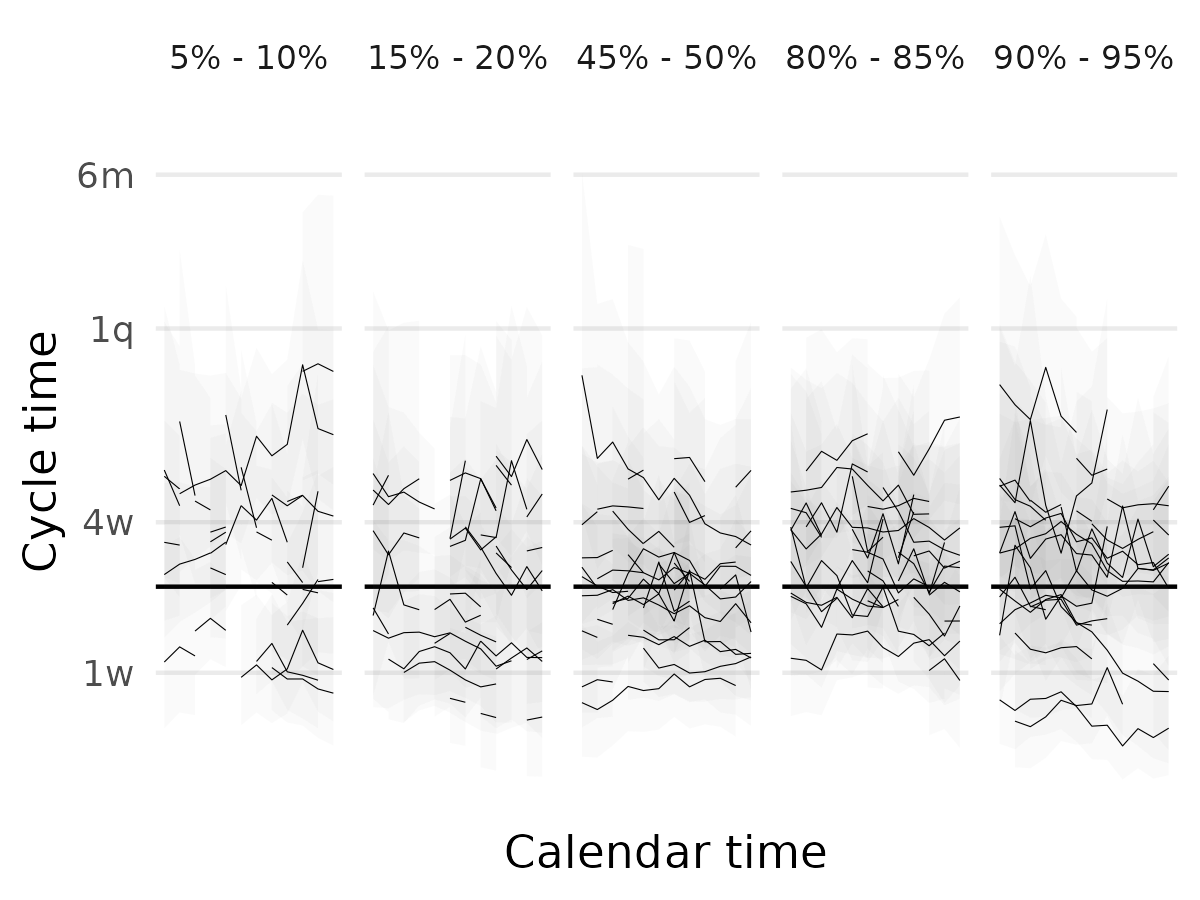
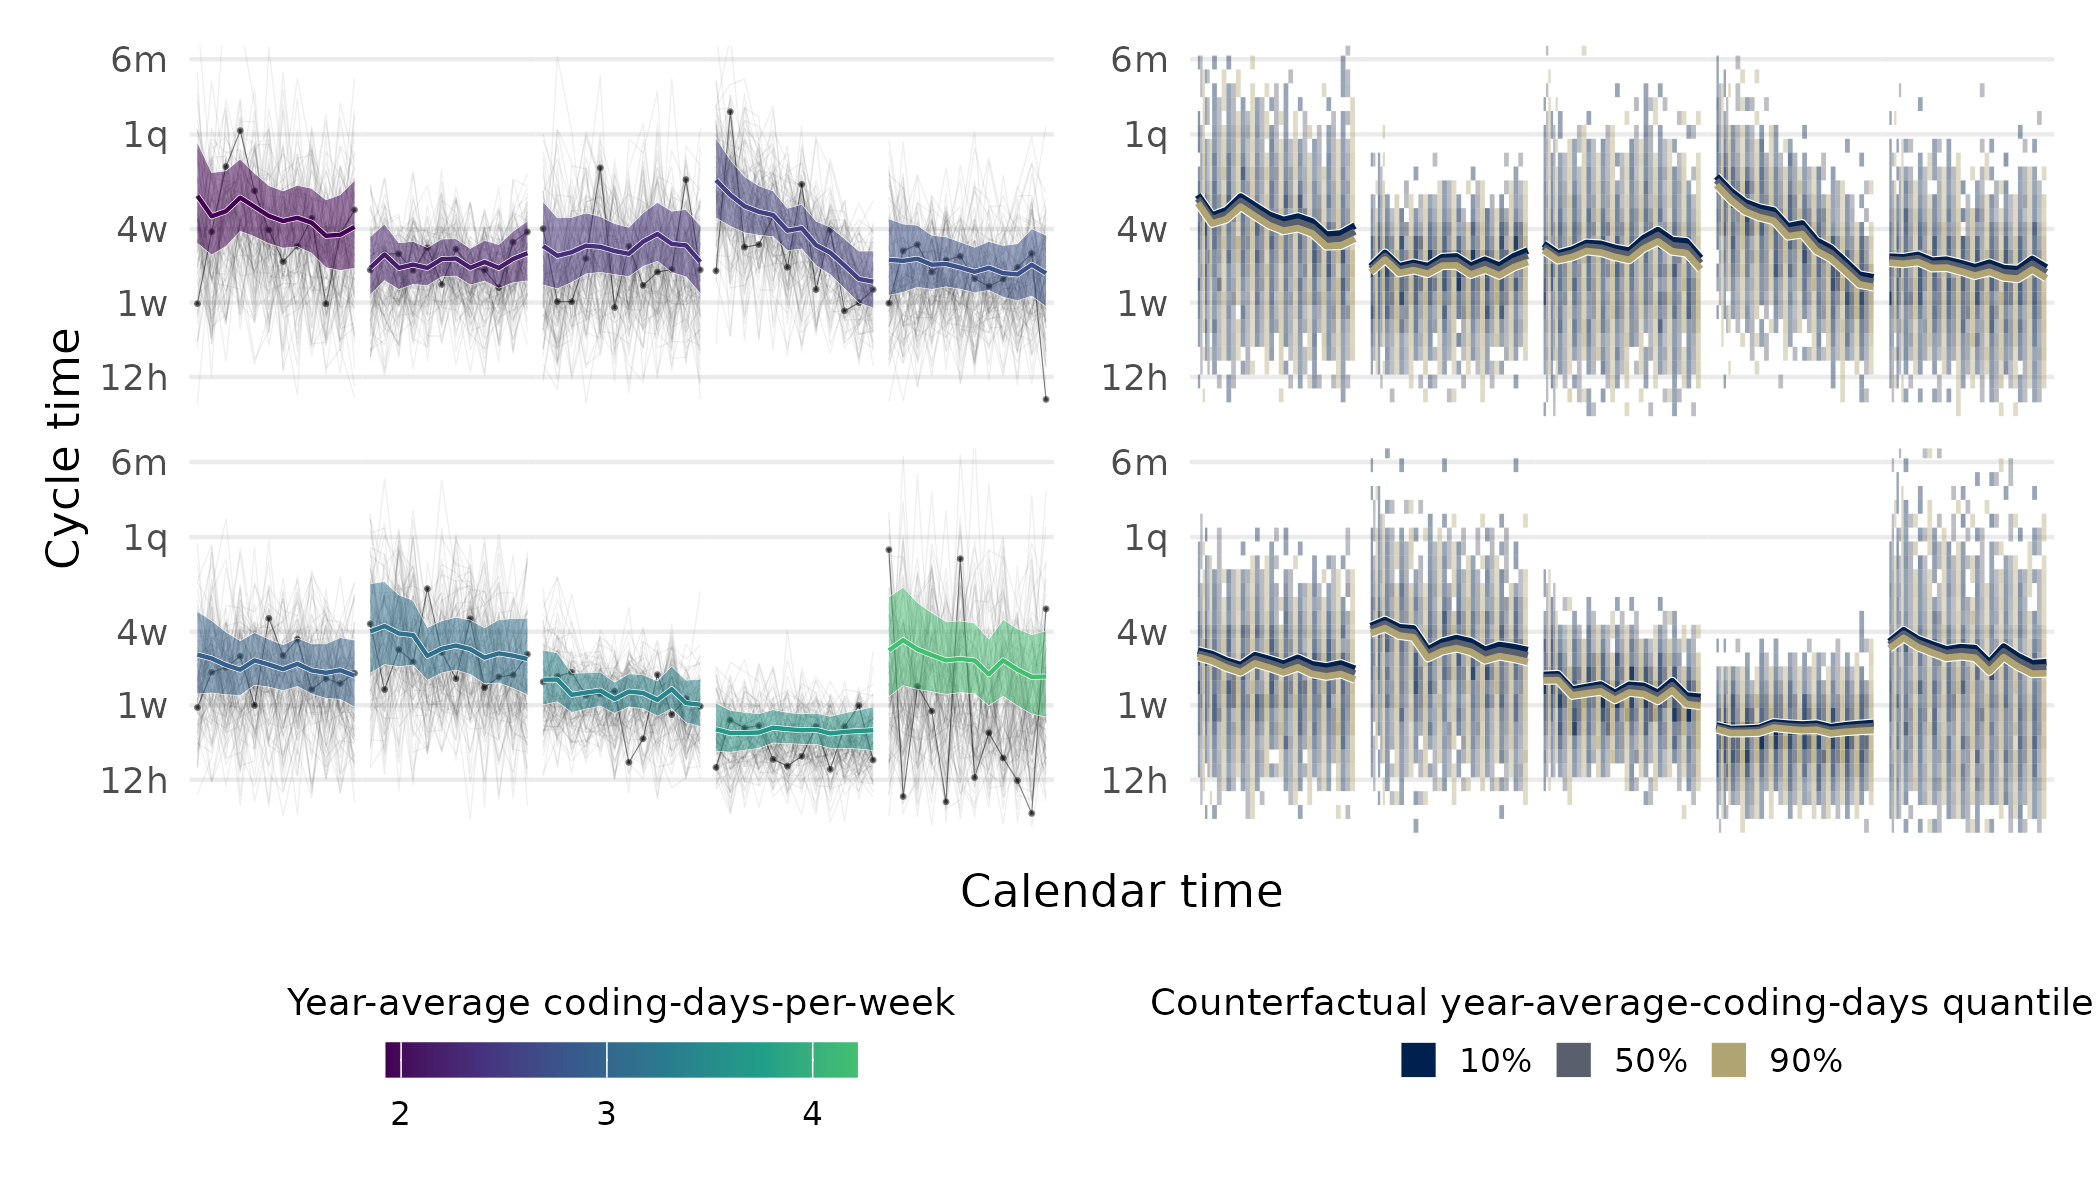
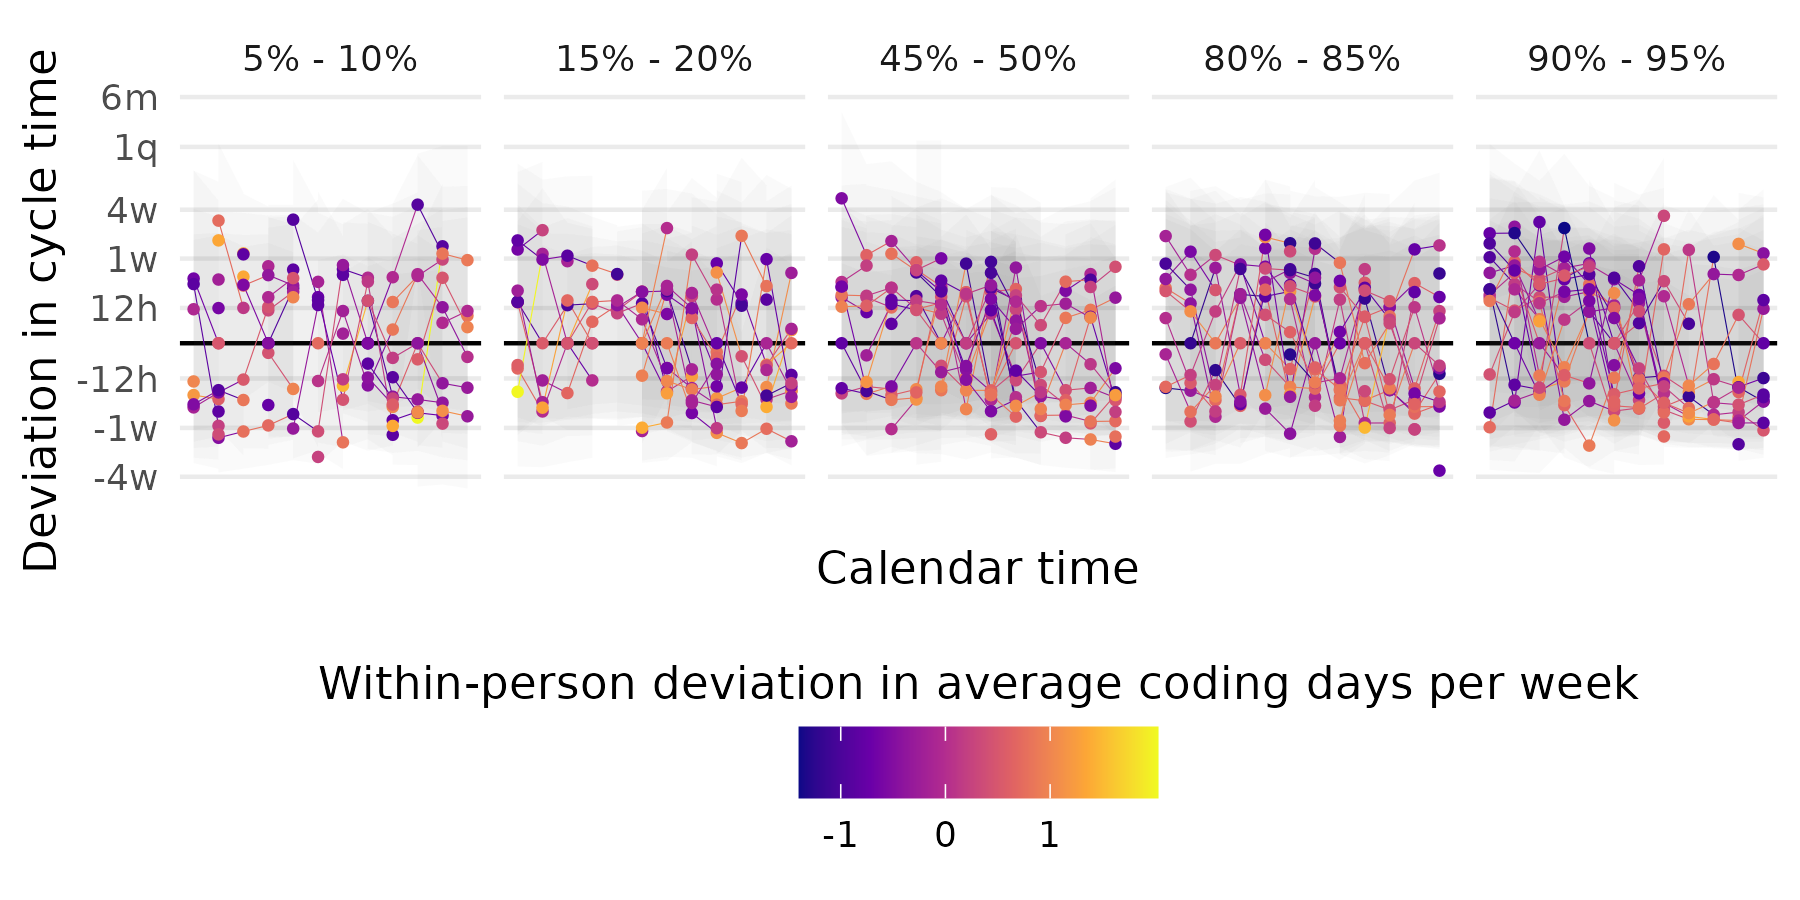
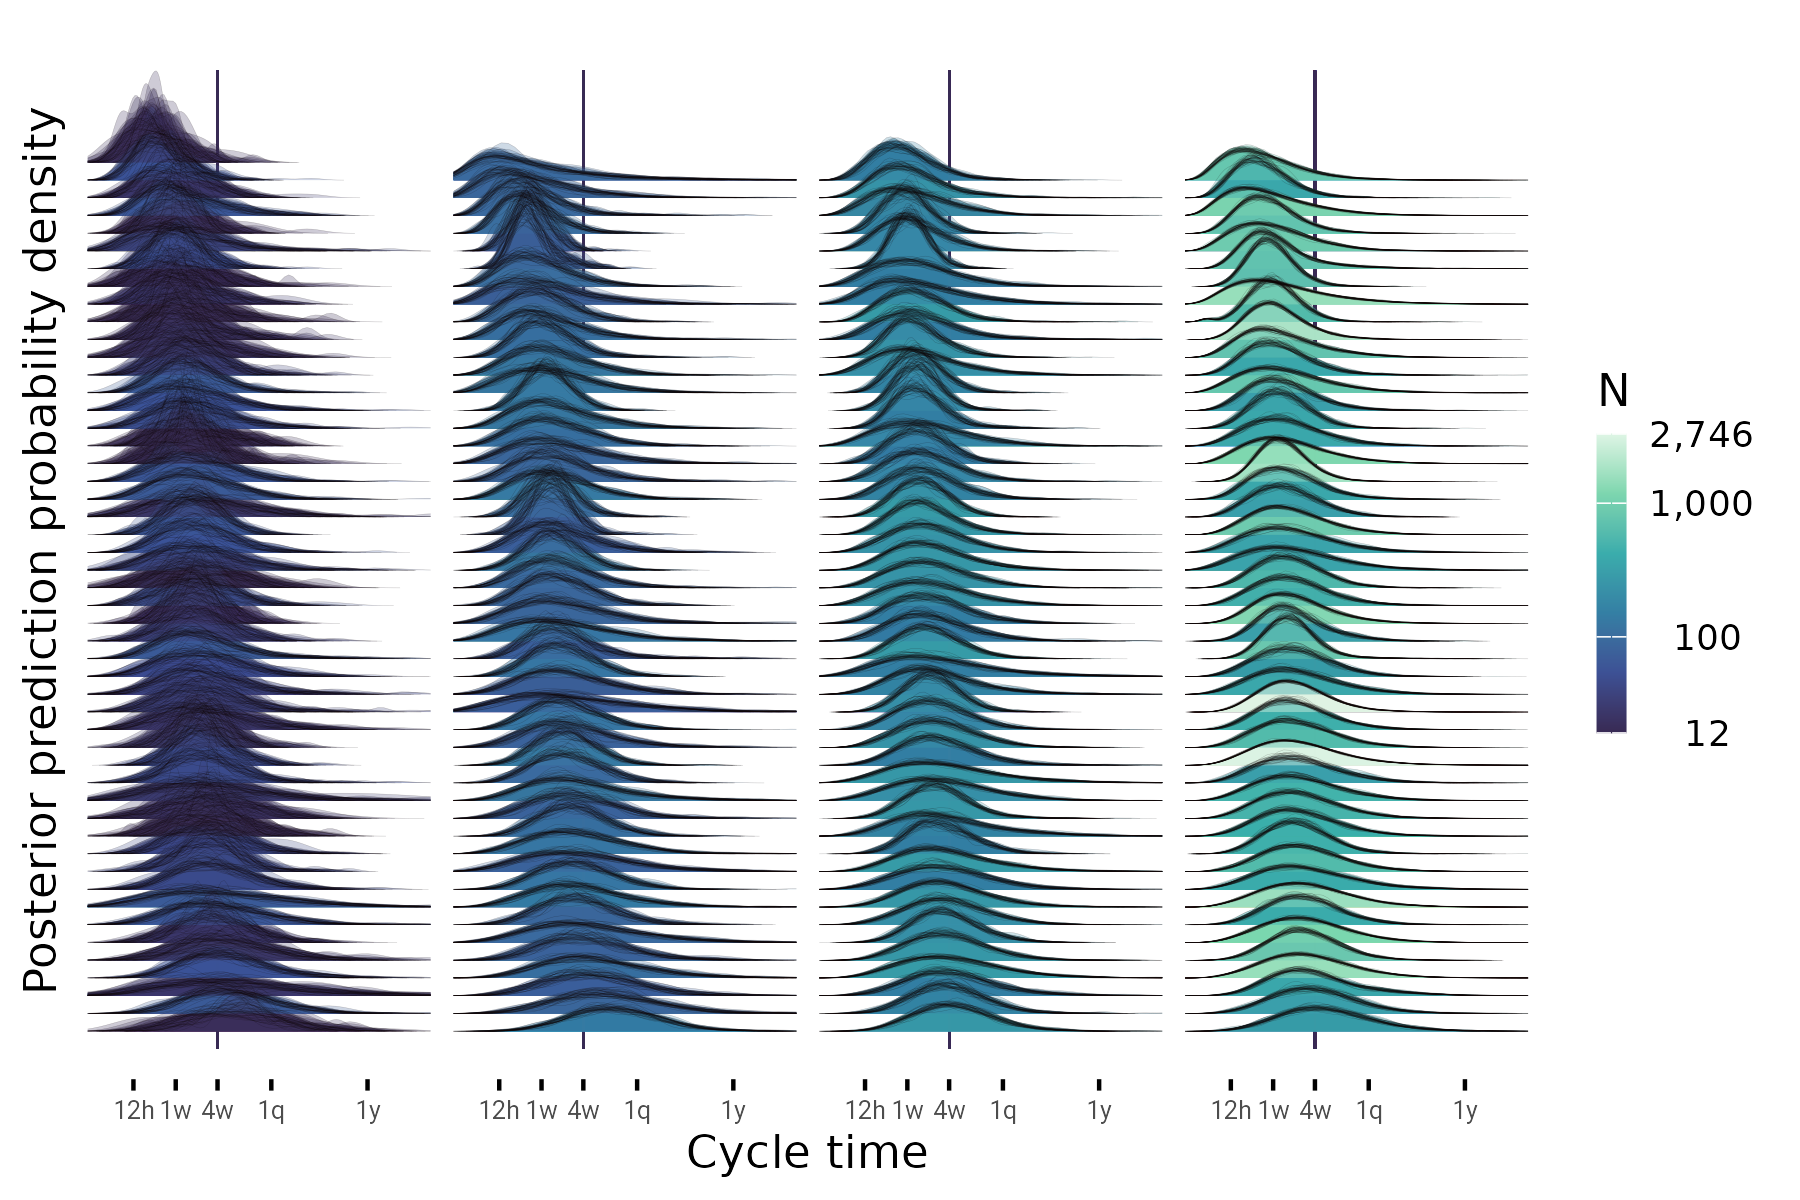